# Import Libraries

In [1]:
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # Remove warning messages

import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import logging
logging.getLogger('tensorflow').disabled = True

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Remove WARNING Messages

import tensorflow as tf
from tensorflow import keras

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Define Functions for Computing Trade Signals


## compute_trade_signals 
Uses simple moving averages of 20 days and 100 days, and compute trade signals based on T and T-1 (refer to equation 15 of the reference paper)


## compute_trade_signals_predicted
Uses simple moving averages of 20 days and 100 days, and compute trade signals based on T and T+1 (refer to equation 19 of the reference paper)


## plot_price 
Plot original stock 'Close' price
Plot FMA and SMA based on predicted 'Close' price
Plot Buy and Sell signals based on predicted 'Close' price


## compute_returns 
Compute portfolio returns based on Buy and Sell signals from predicted 'Close' price whilst using original 'Close' price

The computation of portfolio returns in this section is based on the multiplicative returns given by (refer equation 11 of the reference paper)
𝑅(𝑇)={1+𝐹(𝑇−1)𝑟(𝑇)}{1−𝛿|𝐹(𝑇)−𝐹(𝑇−1)|} 
where   𝑟(𝑇)=(𝑦(𝑇)/𝑦(𝑇−1))−1 ;  
        𝑦(𝑇)  is the closing price at time  𝑇 ;  
        𝐹(𝑇)  is the action from the trading system; and  𝛿  is the transaction rate.
        
The multplicative profits  𝑅  can computed using
𝑅=∏𝑅(𝑇) , from T = 1 through n
where  𝑛  is the total number of time points.


## compare_trade_signals
Plots 'Close', SMA, FMA from original dataframe together with the trade signals from the models vs without forecast

Reference Paper: Ang, K. K., & Quek, C. (2006). Stock Trading Using RSPOP: A Novel Rough Set-Based Neuro-Fuzzy Approach. IEEE Trans. Neural Netw., 17(5), 1301-1315. doi:http://dx.doi.org/10.1109/TNN.2006.875996


In [2]:
# Uses simple moving averages of 20 days and 100 days, and compute trade signals based on T and T-1
def compute_trade_signals(tdf, plt_pos, plt_trade):
    # Fast Moving Average (FMA) set at 20 days
    # Slow Moving Average (SMA) set at 100 days
    tdf['FMA'] = tdf['Close'].rolling(window = 20, min_periods = 1).mean()
    tdf['SMA'] = tdf['Close'].rolling(window = 100, min_periods = 1).mean()

    # Signal happens whenever a crossover happens from one data sample to the next
    # If 0 to 1, means FMA goes above SMA, indicating upward trend
    # If 1 to 0, means FMA goes below SMA, indicating downward trend
    tdf['Signal'] = 0.0
    tdf['Signal'] = np.where(tdf['FMA'] > tdf['SMA'], 1.0, 0.0)

    # Position shows the difference in signal
    # 1 means signal changed from 0 to 1
    # 0 means signal 0 to 0 or 1 to 1
    # -1 means signal changed from 1 to 0
    tdf['Position'] = tdf['Signal'].diff()
    # Need to set the first row of Position to 0. Otherwise it is nan from diff function.
    tdf['Position'].iloc[0]=0

    if plt_pos == True:
        # Plot the positions
        plt.figure(figsize = (20,10))
        plt.title('Position', fontsize = 20)
        tdf['Position'].plot(color = 'k', label= 'Position') 

    # Trade to tell us when to buy (position from -1 to 1) or sell (position from 1 to -1)
    # Uses T and T-1 
    tdf['Trade'] = tdf['Position']
    prevrow = tdf.iloc[0]
    for index, row in tdf.iloc[1:].iterrows():
        if row['Trade']==0:
            if prevrow['Trade']!=0:
                tdf.at[index,'Trade']=prevrow['Trade']
            row['Trade']=prevrow['Trade']
        prevrow=row
        
    if plt_trade==True:
        # Plot the trade
        plt.figure(figsize = (20,10))
        plt.title('Trade', fontsize = 20)
        tdf['Trade'].plot(color = 'r', label= 'Trade')

# Uses simple moving averages of 20 days and 100 days, and compute trade signals based on T and T+1
def compute_trade_signals_predicted(tdf, plt_pos, plt_trade):
    # Fast Moving Average (FMA) set at 20 days
    # Slow Moving Average (SMA) set at 100 days
    tdf['FMA'] = tdf['Close'].rolling(window = 20, min_periods = 1).mean()
    tdf['SMA'] = tdf['Close'].rolling(window = 100, min_periods = 1).mean()

    # Signal happens whenever a crossover happens from one data sample to the next
    # If 0 to 0 or 1 to 1, means no crossover
    # If 0 to 1, means FMA goes above SMA, indicating upward trend
    # If 1 to 0, means FMA goes below SMA, indicating downward trend
    tdf['Signal'] = 0.0
    tdf['Signal'] = np.where(tdf['FMA'] > tdf['SMA'], 1.0, 0.0)

    # Position shows the difference in signal
    # 1 means signal changed from 0 to 1 (Buy)
    # 0 means signal 0 to 0 or 1 to 1 (Do nothing)
    # -1 means signal changed from 1 to 0 (Sell)
    tdf['Position'] = tdf['Signal'].diff()
    # Need to set the first row of Position to 0. Otherwise it is nan from diff function.
    tdf['Position'].iloc[0]=0

    if plt_pos == True:
        # Plot the positions
        plt.figure(figsize = (20,10))
        plt.title('Position', fontsize = 20)
        tdf['Position'].plot(color = 'k', label= 'Position') 

    # Trade to tell us when to buy (position from -1 to 1) or sell (position from 1 to -1)
    # Uses T and T+1 
    tdf['Trade'] = tdf['Position']
    for i in range(1,len(tdf)):
        if i != len(tdf)-1:
            if tdf['Trade'].iloc[i] == 0:
                if tdf['Trade'].iloc[i+1] == 0:
                    tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i-1]
                elif tdf['Trade'].iloc[i+1] != 0:
                    tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i+1]
        else:
            tdf['Trade'].iloc[i] = tdf['Trade'].iloc[i-1]
        
    if plt_trade==True:
        # Plot the trade
        plt.figure(figsize = (20,10))
        plt.title('Trade', fontsize = 20)
        tdf['Trade'].plot(color = 'r', label= 'Trade')


# Plot Original 'Close' Price, and SMA FMA, Buy and Sell signals from predicted 'Close' Price
def plot_price(tdf, time_period):
    # if tdf is a zoomed in timeframe, set time_period to True, else set to False
    if time_period == False:
        # Plot original 'Close' price
        plt.figure(figsize = (20,10))
        df['Close'].plot(color = 'k', label= 'Close')

        # Plot FMA and SMA of tdf
        tdf['FMA'].plot(color = 'b', label = 'FMA') 
        tdf['SMA'].plot(color = 'g', label = 'SMA')

        # Plot buy and sell signals of tdf
        plt.plot(tdf[tdf['Position'] == 1].index, tdf['FMA'][tdf['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
        plt.plot(tdf[tdf['Position'] == -1].index, tdf['FMA'][tdf['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')

        plt.ylabel('Price', fontsize = 15 )
        plt.xlabel('Date', fontsize = 15 )
        plt.title('Challenger', fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show()
    
    else:
        time_period_start = tdf.index[0]
        time_period_end = tdf.index[-1]
        
        # Plot original 'Close' price
        plt.figure(figsize = (20,10))
        df.loc[time_period_start:time_period_end]['Close'].plot(color = 'k', label= 'Close')
        
        # Plot FMA and SMA of tdf
        tdf['FMA'].plot(color = 'b', label = 'FMA') 
        tdf['SMA'].plot(color = 'g', label = 'SMA')

        # Plot buy and sell signals of tdf
        plt.plot(tdf[tdf['Position'] == 1].index, tdf['FMA'][tdf['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
        plt.plot(tdf[tdf['Position'] == -1].index, tdf['FMA'][tdf['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')

        plt.ylabel('Price', fontsize = 15 )
        plt.xlabel('Date', fontsize = 15 )
        plt.title('Challenger', fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show()

        
# Compute portfolio returns based original 'Close' price and Buy and Sell signals from predicted 'Close' price
def compute_returns(tdf,transaction_rate):
    tdf['Returns']=1.0
    prevrow = tdf.iloc[0]
    returncol=tdf.columns.get_loc('Returns')
    for i in range(len(tdf)):
        if i==0:
            prev_i=i
        else:
            # Original 'Close' price return ratio
            prevrow_rt=df.iloc[prev_i]
            row_rt=df.iloc[i]
            rt=(row_rt['Close']/prevrow_rt['Close'])-1
            
            # Compute returns based on trade signals from predicted price
            prevrow=tdf.iloc[prev_i]
            row=tdf.iloc[i]
            t=prevrow['Returns']*(1+prevrow['Trade']*rt)*(1-transaction_rate*abs(row['Trade']-prevrow['Trade']))
            tdf.iat[i,returncol]=t
            prev_i=i
    return tdf


# Plots 'Close', SMA, FMA from original dataframe together with the trade signals from the models vs without forecast
def compare_trade_signals(time_period, date_start, date_end):
    # if time_period set to True, provided date_start & date_end 
    # if time_period set to False, set date_start & date_end to '0'
    with plt.style.context('default'):
        if time_period == True:

            #define subplots
            fig,ax = plt.subplots(figsize = (20,10))
            ax.set_title(f'Close Price and Trading Signals from Date {date_start} to {date_end}', fontsize=20)

            #add first axis plots
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['Close'], color = 'k', label= 'Close')
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['SMA'], color = 'b', label = 'SMA')
            ax.plot(df[date_start:date_end].index, df[date_start:date_end]['FMA'], color = 'y', label = 'FMA')
            ax.legend(loc=2, fontsize=15)
            #add x-axis label
            ax.set_xlabel('Date', fontsize=15)

            #add y-axis label
            ax.set_ylabel('Close Price', fontsize=15)

            #define second y-axis that shares x-axis with current plot
            ax2 = ax.twinx()

            #add second axis plots
            ax2.plot(df[date_start:date_end].index, df[date_start:date_end]['Trade'], color = 'k', linestyle = '-', label = 'Without Forecaset')
            ax2.plot(df2[date_start:date_end].index, df2[date_start:date_end]['Trade'], color = 'g', linestyle = '--', label = 'DENFIS Forecaset')
            ax2.plot(df3[date_start:date_end].index, df3[date_start:date_end]['Trade'], color = 'r', linestyle = ':', label = 'ANFIS Forecaset')
            ax2.legend(loc=6, fontsize=15)
            
            #add second y-axis label
            ax2.set_ylabel('Trading Signal', fontsize=15)
            ax2.set_ylim(-1, 10)

        else:

            #define subplots
            fig,ax = plt.subplots(figsize = (20,10))
            ax.set_title('Close Price and Trading Signals', fontsize=20)

            #add first line to plot
            ax.plot(df.index, df['Close'], color = 'k', label= 'Close')
            ax.plot(df.index, df['SMA'], color = 'b', label = 'SMA')
            ax.plot(df.index, df['FMA'], color = 'y', label = 'FMA')
            ax.legend(loc=2, fontsize=15)
            #add x-axis label
            ax.set_xlabel('Date', fontsize=15)

            #add y-axis label
            ax.set_ylabel('Close Price', fontsize=15)

            #define second y-axis that shares x-axis with current plot
            ax2 = ax.twinx()

            #add second line to plot
            ax2.plot(df.index, df['Trade'], color = 'k', linestyle = '-', label = 'Without Forecaset')
            ax2.plot(df2.index, df2['Trade'], color = 'g', linestyle = '--', label = 'DENFIS Forecaset')
            ax2.plot(df3.index, df3['Trade'], color = 'r', linestyle = ':', label = 'ANFIS Forecaset')
            ax2.legend(loc=6, fontsize=15)
            #add second y-axis label
            ax2.set_ylabel('Trading Signal', fontsize=15)
            ax2.set_ylim(-1, 10)

# Define Evolving Clustering Method


## ECM_init
Initialize ECM parameter


## ECM
ECM algorithm

In [3]:
def ECM_init(X_input, D_thr):
    Clusters = {}
    Clusters[0] = [X_input[0]]
    Clusters_center = {}
    Clusters_center[0] = X_input[0]
    Clusters_radius = []
    Clusters_radius = np.append(Clusters_radius, 0)
    D_threshold = D_thr
    return Clusters, Clusters_center, Clusters_radius, D_threshold


def ECM(X_input, D_thr):
    
    # Initialize ECM variables
    Clusters, Clusters_center, Clusters_radius, D_threshold = ECM_init(X_input, D_thr)
    
    X_data = X_input[1:]
    num_features = len(X_data[0])

    for i in range(len(X_data)):
        num_clusters = len(list(Clusters_center.keys()))

        # create and calculate array of euclidean distance of datapoint i to centers of existing clusters
        d = np.zeros(num_clusters)
        for j in range(num_clusters):
            d[j] = ((((X_data[i] - Clusters_center[j])**2).sum())**0.5) / (num_features**0.5)
            
        # get index of nearest cluster
        nearest_cluster = np.argmin(d)

        # put datapoint i into nearest cluster if datapoint within radius of nearest cluster
        if d[nearest_cluster] <= Clusters_radius[nearest_cluster]:
            cluster_data = Clusters[nearest_cluster]
            Clusters[nearest_cluster] = np.append(cluster_data, [X_data[i]], axis=0)

        else:
            # compute s
            s = np.zeros(num_clusters)
            for j in range(num_clusters):
                s[j] = d[j] + Clusters_radius[j]
            # get index of nearest cluster
            nearest_cluster = np.argmin(s)

            # create new cluster if datapoint is outside of threshold
            if s[nearest_cluster] > 2*D_thr:
                Clusters[len(Clusters.keys())] = [X_data[i]]
                Clusters_center[len(Clusters.keys())-1] = X_data[i]
                Clusters_radius = np.append(Clusters_radius, 0)

            # put datapoint into nearest cluster, then compute new center and radius of cluster
            else:
                cluster_data = Clusters[nearest_cluster]
                Clusters[nearest_cluster] = np.append(cluster_data, [X_data[i]], axis=0)

                if Clusters_radius[nearest_cluster] < D_thr:
                    Clusters_radius[nearest_cluster] = s[nearest_cluster] / 2 ## Original
                    v = Clusters_center[nearest_cluster] - X_data[i]
                    v_mag = ((v**2).sum())**0.5
                    v_unit = v / (v_mag) 
                    Clusters_center[nearest_cluster] = X_data[i] + v_unit*Clusters_radius[nearest_cluster] ## Original
                   
                else: 
                    print(f'\Cluster radius > D_thr')
    
    num_clusters = len(list(Clusters_center.keys()))
    Clusters_center = np.asarray(list(Clusters_center.values())).astype('float32')
    print(f'Total number of clusters: {num_clusters}')
    for i in range(num_clusters):
        print(f'Cluster {i} center: {Clusters_center[i]} with radius {Clusters_radius[i]} and {len(Clusters[i])} datapoints inside')
    return Clusters, Clusters_center, Clusters_radius, D_threshold


# Hybrid AI Method: Define DENFIS Algorithm Structure

In [4]:
# parameter class fis parameters
class denfis_parameters():
    def __init__(self, clusters_center, batch_size: int, n_epochs: int, optimizer: str = 'sgd', loss: str = 'mse'):
        self.n_input = len(clusters_center[0]) # no. of features
        self.m_input = len(clusters_center) # no. of membership functions AKA clusters
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.loss = loss


# Main Class DENFIS
class DENFIS:
    def __init__(self, clusters_center, D_thr: float, batch_size: int, name: str = 'denfis'):

        self.n = len(clusters_center[0]) # no. of features
        self.m = len(clusters_center) # no. of memberhip functions AKA clusters
        self.batch_size = batch_size
        
        input_ = keras.layers.Input(shape=(self.n), name='input_Layer', batch_size=self.batch_size)
        print(f'input_ type: {type(input_)} and shape {input_.shape}')
        
        L1 = Fuzzy_Layer(clusters_center, D_thr, name='fuzzy_layer')(input_)
        print(f'L1 output type: {type(L1)} and shape {L1.shape}')
        
        L2 = Rule_Firing_Layer(clusters_center, name='rule_firing_layer')(L1)
        print(f'L2 output type: {type(L2)} and shape {L2.shape}')
        
        L3 = Norm_Layer(name='norm_Layer')(L2)
        print(f'L3 output type: {type(L3)} and shape {L3.shape}')
        
        L4 = Consequent_Layer(clusters_center, name='consequent_layer')(L3, input_)
        print(f'L4 output type: {type(L4)} and shape {L4.shape}')
        
        L5 = Output_Layer(name='output_layer')(L4)
        print(f'L5 output type: {type(L5)} and shape {L5.shape}')
        
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        # premise parameters
        self.beta = self.model.get_layer('fuzzy_layer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer('consequent_layer').get_weights()


    def fit(self, X, y, **kwargs):
        # save initial weights in the denfis class
        self.init_weights = self.model.get_layer('fuzzy_layer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history


# Layer 1
class Fuzzy_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, D_thr, **kwargs):
        super(Fuzzy_Layer, self).__init__(**kwargs)
        self.clusters_center = clusters_center
        self.D_thr = D_thr
        self.n = len(clusters_center[0])
        self.m = len(clusters_center)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        self.beta = self.add_weight(name='beta',
                                    shape=(self.m, self.n),
                                    initializer=keras.initializers.RandomUniform(minval=1.2, maxval=2.0, seed=1),
                                    constraint=lambda x: tf.clip_by_value(x, 1.2, 2.0),
                                    trainable=True) 
        super(Fuzzy_Layer, self).build(batch_input_shape)

    def call(self, x_inputs):
        x_inputs = tf.cast(x_inputs, tf.float32)
        self.b = self.clusters_center
        self.a = tf.math.subtract(self.b, (tf.math.multiply(self.beta, self.D_thr)))        
        self.c = tf.math.add(self.b, (tf.math.multiply(self.beta, self.D_thr)))
        x_input = tf.reshape(tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n))
        L1_output = tf.maximum(
                               tf.minimum(tf.divide(tf.subtract(x_input, self.a), tf.subtract(self.b, self.a)),
                                          tf.divide(tf.subtract(self.c, x_input), tf.subtract(self.c, self.b))),
                               0)
        return L1_output # Fuzzy layer output


# Layer 2
class Rule_Firing_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, **kwargs):
        super(Rule_Firing_Layer, self).__init__(**kwargs)
        self.batch_size = None

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        super(Rule_Firing_Layer, self).build(batch_input_shape)

    def call(self, input_):        
        L2_output = tf.math.reduce_prod(input_, axis=2)
        return L2_output # Rule Firing layer output


# Layer 3
class Norm_Layer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm # Normalize layer output


# Layer 4
class Consequent_Layer(keras.layers.Layer):
    def __init__(self, clusters_center, **kwargs):
        super().__init__(**kwargs)
        self.n = len(clusters_center[0])
        self.m = len(clusters_center)
        self.bias = self.add_weight(name='Consequence_bias',
                                    shape=(1, self.m),
                                    initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                    trainable=True)
        self.weight = self.add_weight(name='Consequence_weight',
                                      shape=(self.n, self.m),
                                      initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                      trainable=True)

    def call(self, w_norm, input_):
        L4_L2_output = tf.multiply(w_norm,tf.matmul(input_, self.weight) + self.bias)
        return L4_L2_output # Consequent layer output


# Layer 5
class Output_Layer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        super(Output_Layer, self).build(batch_input_shape)

    def call(self, input_):
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output # Output layer output

# BenchmarkMethod: Define ANFIS Algorithm Structure

Sourced from: https://github.com/gregorLen/AnfisTensorflow2.0

In [5]:
# parameter class fis parameters
class fis_parameters():
    def __init__(self, n_input: int = 3, n_memb: int = 3, batch_size: int = 16, n_epochs: int = 25, memb_func: str = 'gaussian', optimizer: str = 'sgd', loss: str = 'mse'):
        self.n_input = n_input  # no. of Regressors
        self.n_memb = n_memb  # no. of fuzzy memberships
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.memb_func = memb_func  # 'gaussian' / 'gbellmf'
        self.optimizer = optimizer   # sgd / adam /
        self.loss = loss  # mse / mae


# Main Class ANFIS
class ANFIS:
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func
        input_ = keras.layers.Input(shape=(n_input), name='inputLayer', batch_size=self.batch_size)
        print(f'input_ type: {type(input_)} and shape {input_.shape}')
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(input_)
        print(f'L1 output type: {type(L1)} and shape {L1.shape}')
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        print(f'L2 output type: {type(L2)} and shape {L2.shape}')
        L3 = NormLayer(name='normLayer')(L2)
        print(f'L3 output type: {type(L3)} and shape {L3.shape}')
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')(L3, input_)
        print(f'L4 output type: {type(L4)} and shape {L4.shape}')
        L5 = SummationLayer(name='sumLayer')(L4)
        print(f'L5 output type: {type(L5)} and shape {L5.shape}')
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        # premise parameters (mu&sigma for gaussian // a/b/c for bell-shaped)
        if self.memb_func == 'gaussian':
            self.mus, self.sigmas = self.model.get_layer(
                'fuzzyLayer').get_weights()
        elif self.memb_func == 'gbellmf':
            self.a, self.b, self.c = self.model.get_layer(
                'fuzzyLayer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer(
            'defuzzLayer').get_weights()

    def plotmfs(self, show_initial_weights=False):
        n_input = self.n
        n_memb = self.m

        if self.memb_func == 'gaussian':
            mus, sigmas = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            mus, sigmas = mus.reshape(
                (n_memb, n_input, 1)), sigmas.reshape(n_memb, n_input, 1)

            xn = np.linspace(0, 1, 10001).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = np.exp(-np.square((xn - mus)) / np.square(sigmas))

            if show_initial_weights:
                mus_init, sigmas_init = np.around(self.init_weights, 2)
                mus_init, sigmas_init = mus_init.reshape(
                    n_memb, n_input, 1), sigmas_init.reshape(n_memb, n_input, 1)
                init_curves = np.exp(-np.square((xn - mus_init)
                                                ) / np.square(sigmas_init))

        elif self.memb_func == 'gbellmf':
            a, b, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            a, b, c = a.reshape((n_memb, n_input, 1)), b.reshape(
                n_memb, n_input, 1), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - np.max(abs(a)),
                             np.max(c) + np.max(abs(a)), 10001).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.square((xn - c) / a)**b)

            if show_initial_weights:
                a_init, b_init, c_init = np.around(self.init_weights, 2)
                a_init, b_init, c_init = a_init.reshape((n_memb, n_input, 1)), b_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / \
                    (1 + np.square((xn - c_init) / a_init)**b_init)

        elif self.memb_func == 'sigmoid':
            gammas, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            gammas, c = gammas.reshape(
                (n_memb, n_input, 1)), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - np.max(abs(c)), np.max(c) + np.max(
                abs(c)), 10001).reshape((1, 1, -1))  
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.exp(-gammas * (xn - c)))

            if show_initial_weights:
                gammas_init, c_init = np.around(self.init_weights, 2)
                gammas_init, c_init = gammas_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / (1 + np.exp(-gammas_init * (xn - c_init)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(10,10))
        fig.suptitle('Membership functions', size=16)
        for n in range(self.n):
            axs[n].grid(True)
            axs[n].set_title(f'Input {n+1}')
            for m in range(self.m):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :])

        if show_initial_weights:  # plot initial membership curve
            for n in range(self.n):
                axs[n].set_prop_cycle(None)  # reset color cycle
                for m in range(self.m):
                    axs[n].plot(xn[m, n, :], init_curves[m, n, :],
                                '--', alpha=.5)
        plt.show()

    def fit(self, X, y, **kwargs):
        # save initial weights in the anfis class
        self.init_weights = self.model.get_layer('fuzzyLayer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history

    def get_memberships(self, Xs):
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                               outputs=self.model.get_layer('normLayer').output)

        intermediate_L2_output = intermediate_layer_model.predict(Xs)

        return intermediate_L2_output


# Custom weight initializer
def equally_spaced_initializer(shape, minval=-2.0, maxval=2.0, dtype=tf.float32):
    """
    Custom weight initializer:
        euqlly spaced weights along an operating range of [minval, maxval].
    """
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]),
                          (-1, 1))
    return tf.Variable(tf.tile(linspace, (1, shape[1])))


# Layer 1
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]

        if self.memb_func == 'gbellmf':
            self.a = self.add_weight(name='a', # width of membership
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(minval=0.1, maxval=0.4, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.2, 0.4),
                                     trainable=True)
            self.b = self.add_weight(name='b', # slope of membership
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(minval=0.1, maxval=1.5, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.4, 0.8),
                                     trainable=True)
            self.c = self.add_weight(name='c', # center of membership
                                     shape=(self.m, self.n),
                                     initializer = keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=1),
                                     constraint=lambda x: tf.clip_by_value(x, 0.0, 1.0),
                                     trainable=True)

        elif self.memb_func == 'gaussian':
            self.mu = self.add_weight(name='mu',
                                      shape=(self.m, self.n),
                                      initializer = keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=1),
                                      constraint=lambda x: tf.clip_by_value(x, 0.0, 1.0),
                                      trainable=True)
            self.sigma = self.add_weight(name='sigma',
                                         shape=(self.m, self.n),
                                         initializer=keras.initializers.RandomUniform(minval=0.1, maxval=0.2, seed=1),
                                         constraint=lambda x: tf.clip_by_value(x, 0.1, 0.2),
                                         trainable=True)

        elif self.memb_func == 'sigmoid':
            self.gamma = self.add_weight(name='gamma',
                                         shape=(self.m, self.n),
                                         initializer=equally_spaced_initializer,  # 'ones',
                                         trainable=True)

            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,  # 'ones',
                                     trainable=True)

        # Be sure to call this at the end
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        if self.memb_func == 'gbellmf':
            L1_output = 1 / (1 +
                             tf.math.pow(
                                 tf.square(tf.subtract(
                                     tf.reshape(
                                         tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c
                                 ) / self.a), self.b)
                             )
        elif self.memb_func == 'gaussian':
            L1_output = tf.exp(-1 *
                               tf.square(tf.subtract(
                                   tf.reshape(
                                       tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.mu
                               )) / tf.square(self.sigma))

        elif self.memb_func == 'sigmoid':
            L1_output = tf.math.divide(1,
                                       tf.math.exp(-self.gamma *
                                                   tf.subtract(
                                                       tf.reshape(
                                                           tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c)
                                                   )
                                       )
        return L1_output


# Layer 2
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.batch_size = None

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        # Be sure to call this at the end
        super(RuleLayer, self).build(batch_input_shape)

    def call(self, input_):
        if self.n == 2:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1])
        elif self.n == 3:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1])
        elif self.n == 4:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1])
        elif self.n == 5:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1])
        elif self.n == 6:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 5], [self.batch_size, 1, 1, 1, 1, 1, -1])
        else:
            raise ValueError(
                f'This ANFIS implementation works with 2 to 6 inputs.')
        L2_output = tf.reshape(L2_output, [self.batch_size, -1])
        return L2_output


# Layer 3
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, w):
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm


# Layer 4
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        
        self.bias = self.add_weight(name='Consequence_bias',
                                       shape=(1, self.m ** self.n),
                                       initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                       trainable=True)
        self.weight = self.add_weight(name='Consequence_weight',
                                         shape=(self.n, self.m ** self.n),
                                         initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1),
                                         trainable=True)

    def call(self, w_norm, input_):

        L4_L2_output = tf.multiply(w_norm,
                                   tf.matmul(input_, self.weight) + self.bias)
        return L4_L2_output  # Defuzzyfied Layer


# Layer 5
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.batch_size = batch_input_shape[0]
        #self.batch_size = tf.shape(batch_input_shape)[0]
        # Be sure to call this at the end
        super(SummationLayer, self).build(batch_input_shape)

    def call(self, input_):
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output

# Select Stock Price and Download data

Raw number of samples: 4367
Number of samples after dropping NAN values: 4365


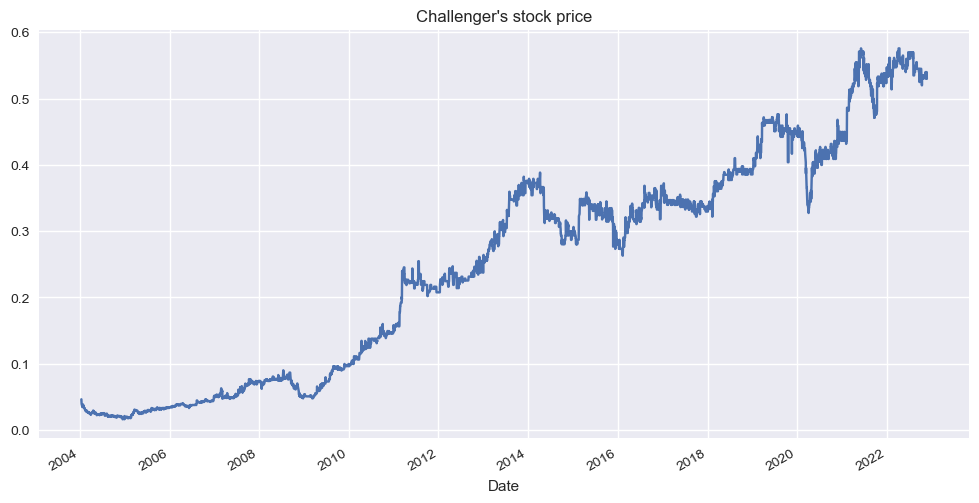

In [6]:
# Select Challenger Stock Price and plot 'Close' price
ticker = yf.Ticker('573.SI') 
chlngr_df = ticker.history(period="max")
figure(figsize=(12, 6))
chlngr_df['Close'].plot(title="Challenger's stock price")

# Drop any NAN values
print(f'Raw number of samples: {len(chlngr_df)}')
chlngr_df = chlngr_df.dropna(axis=0, how='any')
print(f'Number of samples after dropping NAN values: {len(chlngr_df)}')

# Prepare data for ECM & Models

In [7]:
# define number of previous days delta closing prices as features to predict tomorrow's delta closing price
num_days = 3
num_features = num_days
num_rows = len(chlngr_df)
chlngr_df['x_1'] = 0.0 # c(T) - c(T-1)
chlngr_df['x_2'] = 0.0 # c(T-1) - c(T-2)
chlngr_df['x_3'] = 0.0 # c(T-2) - c(T-3)
chlngr_df['y_0'] = 0.0 # c(T+1) - c(T)

for i in range(num_days, num_rows-1):
    chlngr_df['x_1'].iloc[i] = chlngr_df['Close'].iloc[i] - chlngr_df['Close'].iloc[i-1]
    chlngr_df['x_2'].iloc[i] = chlngr_df['Close'].iloc[i-1] - chlngr_df['Close'].iloc[i-2]
    chlngr_df['x_3'].iloc[i] = chlngr_df['Close'].iloc[i-2] - chlngr_df['Close'].iloc[i-3]
    chlngr_df['y_0'].iloc[i] = chlngr_df['Close'].iloc[i+1] - chlngr_df['Close'].iloc[i]

# Save required information to new dataframe
df = chlngr_df.iloc[num_days:num_rows-1][['x_1', 'x_2', 'x_3', 'y_0','Close']]
display(df.head(10))

# Convert dataframe to numpy 
data = df.to_numpy()
X = data[:,0:num_features]
Y = data[:,-2]
Y = Y.reshape(-1,1)

# scale data to [0, 1] for ECM algorithm and models
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
scaler_X.fit(X)
scaler_Y.fit(Y)
X = scaler_X.transform(X)
Y = scaler_Y.transform(Y)

,x_1,x_2,x_3,y_0,Close
Date,,,,,
2004-01-19 00:00:00+08:00,-0.002322,-0.003096,-0.003870,-0.000774,0.037147
2004-01-20 00:00:00+08:00,-0.000774,-0.002322,-0.003096,-0.001548,0.036373
2004-01-21 00:00:00+08:00,-0.001548,-0.000774,-0.002322,0.000000,0.034826
2004-01-22 00:00:00+08:00,0.000000,-0.001548,-0.000774,0.000000,0.034826
2004-01-23 00:00:00+08:00,0.000000,0.000000,-0.001548,0.002322,0.034826
2004-01-26 00:00:00+08:00,0.002322,0.000000,0.000000,0.001548,0.037147
2004-01-27 00:00:00+08:00,0.001548,0.002322,0.000000,-0.002322,0.038695
2004-01-28 00:00:00+08:00,-0.002322,0.001548,0.002322,0.000774,0.036373
2004-01-29 00:00:00+08:00,0.000774,-0.002322,0.001548,-0.000774,0.037147


# DENFIS Model Training

No. of data samples: 4361
No. of training data samples: 2616 with shape (2616, 3)
No. of validation data samples: 654 with shape (654, 3)
No. of testing data samples: 1091 with shape (1091, 3)
num_train_date is 2015-12-15 00:00:00+08:00
num_val_date is 2018-07-24 00:00:00+08:00
Total number of clusters: 6
Cluster 0 center: [0.64698035 0.44412687 0.6113555 ] with radius 0.20794088184217852 and 3417 datapoints inside
Cluster 1 center: [0.19889271 0.54320693 0.52634746] with radius 0.19948777016394748 and 310 datapoints inside
Cluster 2 center: [0.75325197 0.13688624 0.5217914 ] with radius 0.14255646664981086 and 5 datapoints inside
Cluster 3 center: [0.537115   0.58290535 0.18648128] with radius 0.19104082926993615 and 449 datapoints inside
Cluster 4 center: [0.7036154  0.8676906  0.54166687] with radius 0.17881075028038876 and 25 datapoints inside
Cluster 5 center: [0.46136734 0.5549734  0.77690274] with radius 0.1662354399568317 and 155 datapoints inside
input_ type: <class 'keras.eng

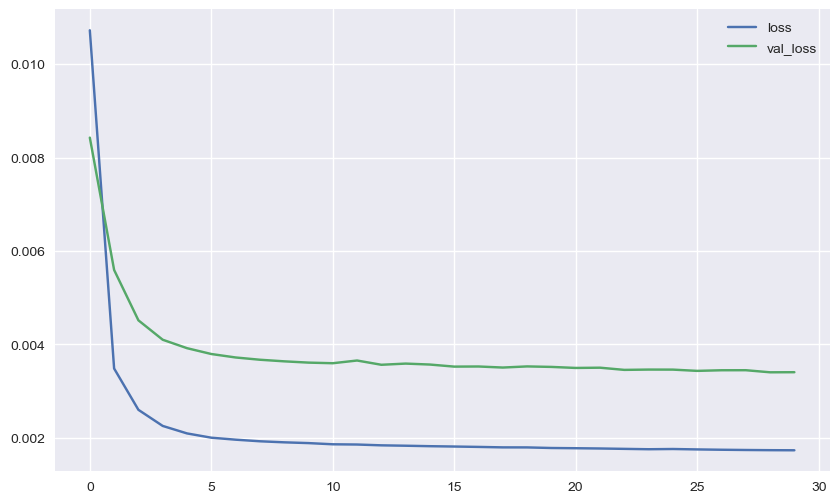

In [8]:
# Split data into 60/15/25 train/val/test datasets
num_train = int(len(X)*0.6)
num_val = int(len(X)*0.75)
num_test = len(X)

X_train = X[0:num_train,:]
y_train = Y[0:num_train]
X_val = X[num_train:num_val,:]
y_val = Y[num_train:num_val]
X_test = X[num_val:num_test,:]
y_test = Y[num_val:num_test]

print(f'No. of data samples: {len(X)}')
print(f'No. of training data samples: {len(X_train)} with shape {X_train.shape}')
print(f'No. of validation data samples: {len(X_val)} with shape {X_val.shape}')
print(f'No. of testing data samples: {len(X_test)} with shape {X_test.shape}')

num_start_date = df.index[0]
num_train_date = df.index[num_train]
num_val_date = df.index[num_val]
print(f'num_train_date is {num_train_date}')
print(f'num_val_date is {num_val_date}')

# Perform ECM on data
Clusters, Clusters_center, Clusters_radius, D_threshold = ECM(X, 0.21)

# Set parameters
param = denfis_parameters(clusters_center=Clusters_center, batch_size=1, optimizer='sgd', loss='mse', n_epochs=30)

denfis_model = DENFIS(clusters_center=Clusters_center, D_thr = D_threshold, batch_size=param.batch_size, name='denfis')

# Compile model
denfis_model.model.compile(optimizer=param.optimizer, loss=param.loss)

# Fit model
history = denfis_model.fit(X_train, y_train, epochs=param.n_epochs, batch_size=param.batch_size, validation_data=(X_val, y_val))

# Plot loss curve and Model summary
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(10, 6))
denfis_model.model.summary()

# Get L1 parameters
beta = denfis_model.model.get_layer('fuzzy_layer').get_weights()

# Get L4 paramters
bias = denfis_model.bias
weights = denfis_model.weights

Plot DENFIS Model Train & Val Predictions

2616/2616 [==============================] - 1s 416us/step


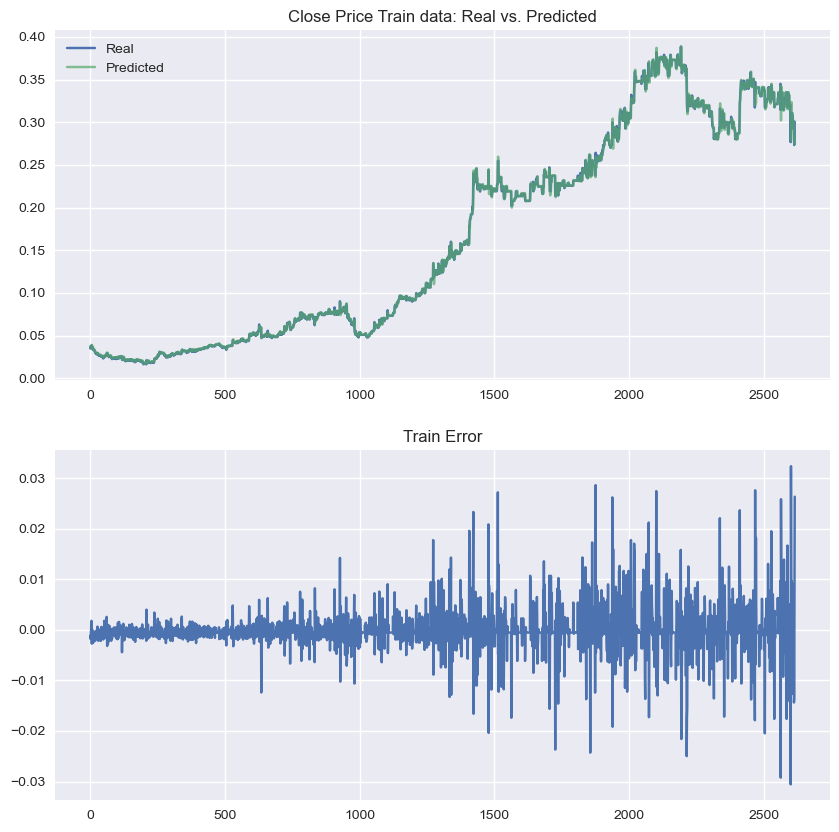

654/654 [==============================] - 0s 418us/step


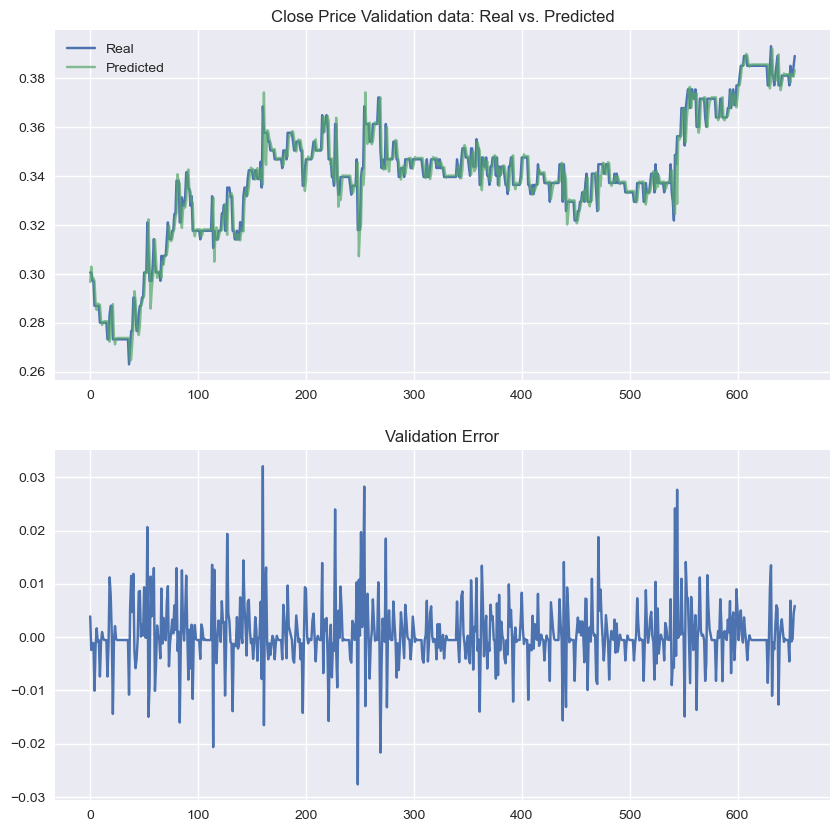

In [9]:
# Predict train data
y_train_pred_b4 = denfis_model(X_train) # predicted scaled delta
y_train_pred = scaler_Y.inverse_transform(y_train_pred_b4) # predicted unscaled delta
y_train_pred = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train_pred # predicted unscaled 'Close' price

# Real train data
y_train = scaler_Y.inverse_transform(y_train) # real unscaled delta
y_train = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train # real unscaled 'Close' price

# Plot real train data vs predicted train data
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_train)
axs[0].plot(y_train_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Train data: Real vs. Predicted')

axs[1].plot(np.arange(y_train.shape[0]), y_train - y_train_pred)
axs[1].grid(True)
axs[1].set_title('Train Error')
plt.show()

# Predict val data
y_val_pred_b4 = denfis_model(X_val) # predicted scaled delta
y_val_pred = scaler_Y.inverse_transform(y_val_pred_b4) # predicted unscaled delta
y_val_pred = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val_pred # predicted unscaled 'Close' price

# Real val data
y_val = scaler_Y.inverse_transform(y_val) # real unscaled delta
y_val = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val # real unscaled 'Close' price

# Plot val data vs predicted of val data   
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_val)
axs[0].plot(y_val_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Validation data: Real vs. Predicted')
axs[1].plot(np.arange(y_val.shape[0]), y_val - y_val_pred)
axs[1].grid(True)
axs[1].set_title('Validation Error')
plt.show()

Plot Multiplicative Returns of DENFIS Train & Val  Predictions vs Baseline

Text(0.5, 0, 'Date')

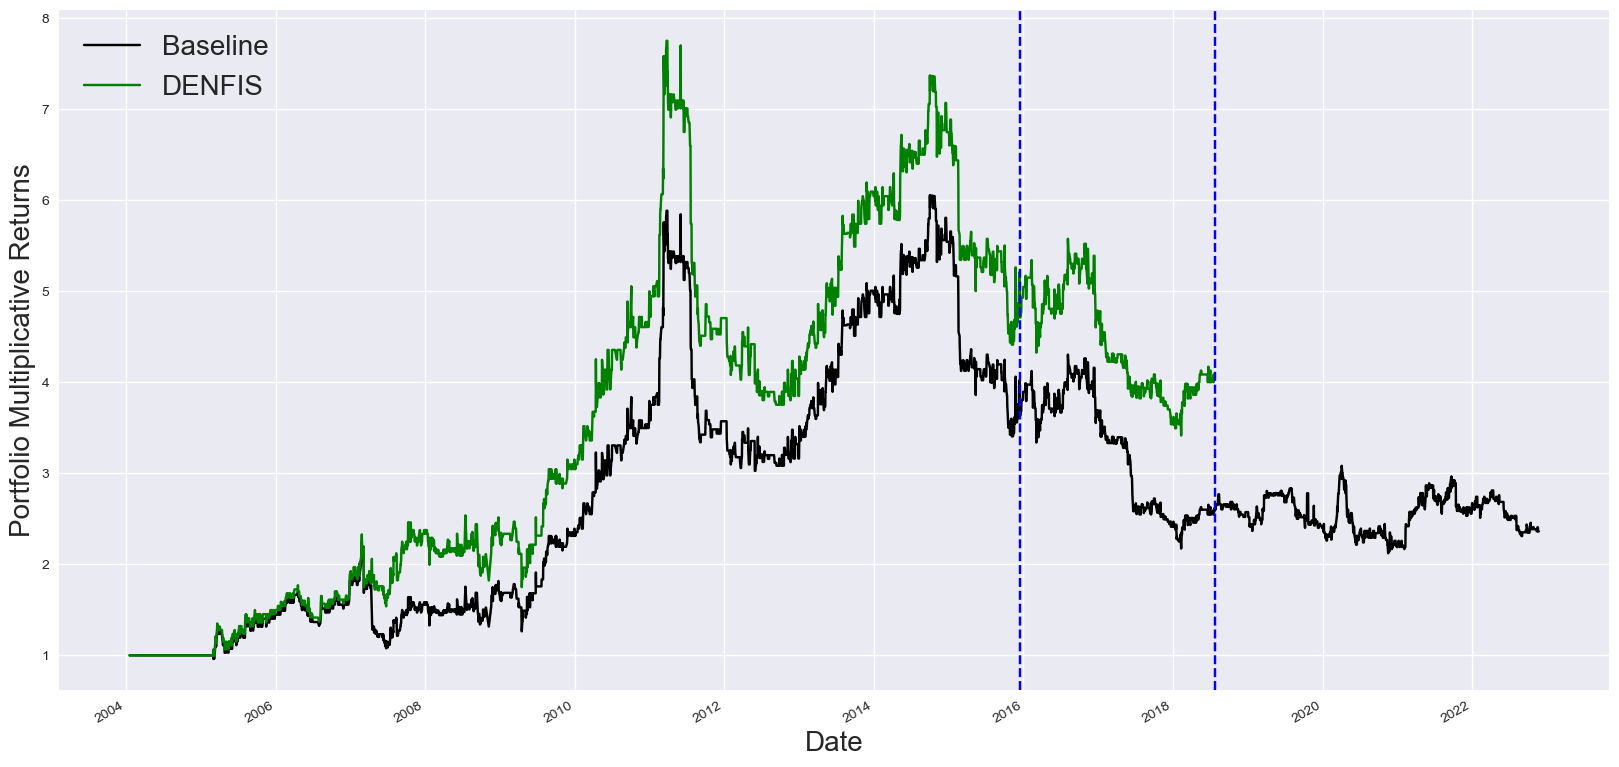

In [10]:
# Place predicted train & val 'Close' prices into df2
predicted = np.concatenate((y_train_pred, y_val_pred))
predicted = predicted[:,0]
index_labels = df.index.array[0:num_val]
df2 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute Baseline Returns
compute_trade_signals(df,plt_pos=False, plt_trade=False)
df = compute_returns(df, 0.005)

# Compute DENFIS Returns
compute_trade_signals_predicted(df2,plt_pos=False, plt_trade=False)
df2 = compute_returns(df2, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

DENFIS Model Test Data Prediction

1091/1091 [==============================] - 0s 436us/step


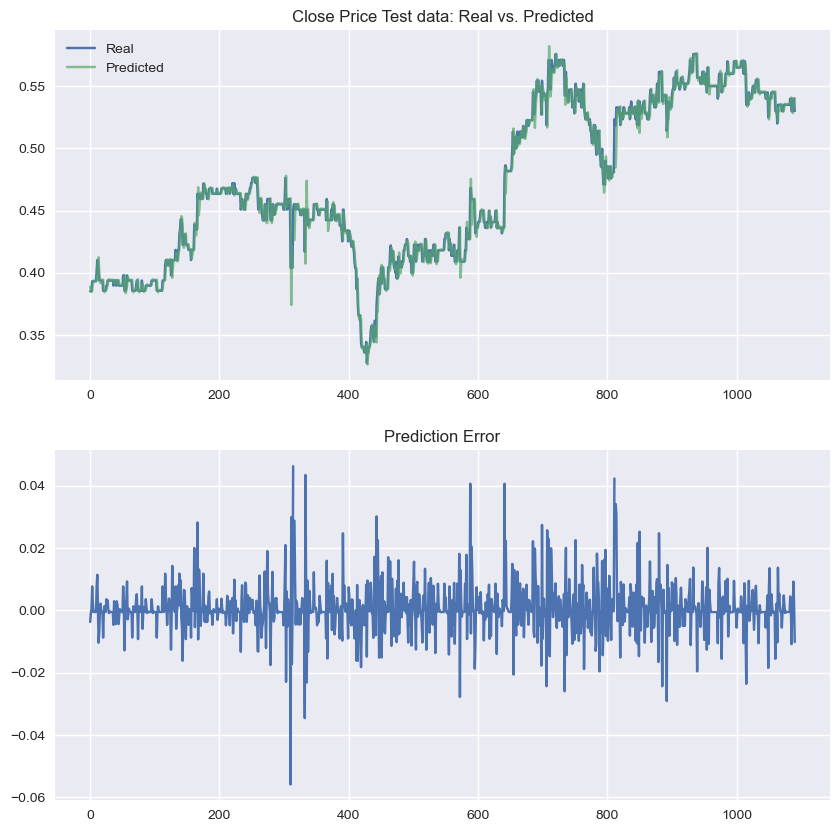

In [11]:
# Plot test data vs predicted of test data
y_test_pred_b4 = denfis_model(X_test) # predicted scaled delta
y_test_pred = scaler_Y.inverse_transform(y_test_pred_b4) # predicted unscaled delta
y_test_pred = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test_pred # predicted unscaled 'Close' price

y_test = scaler_Y.inverse_transform(y_test) # real unscaled delta
y_test = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_test)
axs[0].plot(y_test_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Test data: Real vs. Predicted')
axs[1].plot(np.arange(y_test.shape[0]), y_test - y_test_pred)
axs[1].grid(True)
axs[1].set_title('Prediction Error')
plt.show()


Plot Multiplicative Returns of DENFIS Train, Val & Test Predictions vs Baseline

Start date of df: 2004-01-19 00:00:00+08:00
End date of df: 2022-11-21 00:00:00+08:00
Start date of df2: 2004-01-19 00:00:00+08:00
End date of df2: 2022-11-21 00:00:00+08:00


Text(0.5, 0, 'Date')

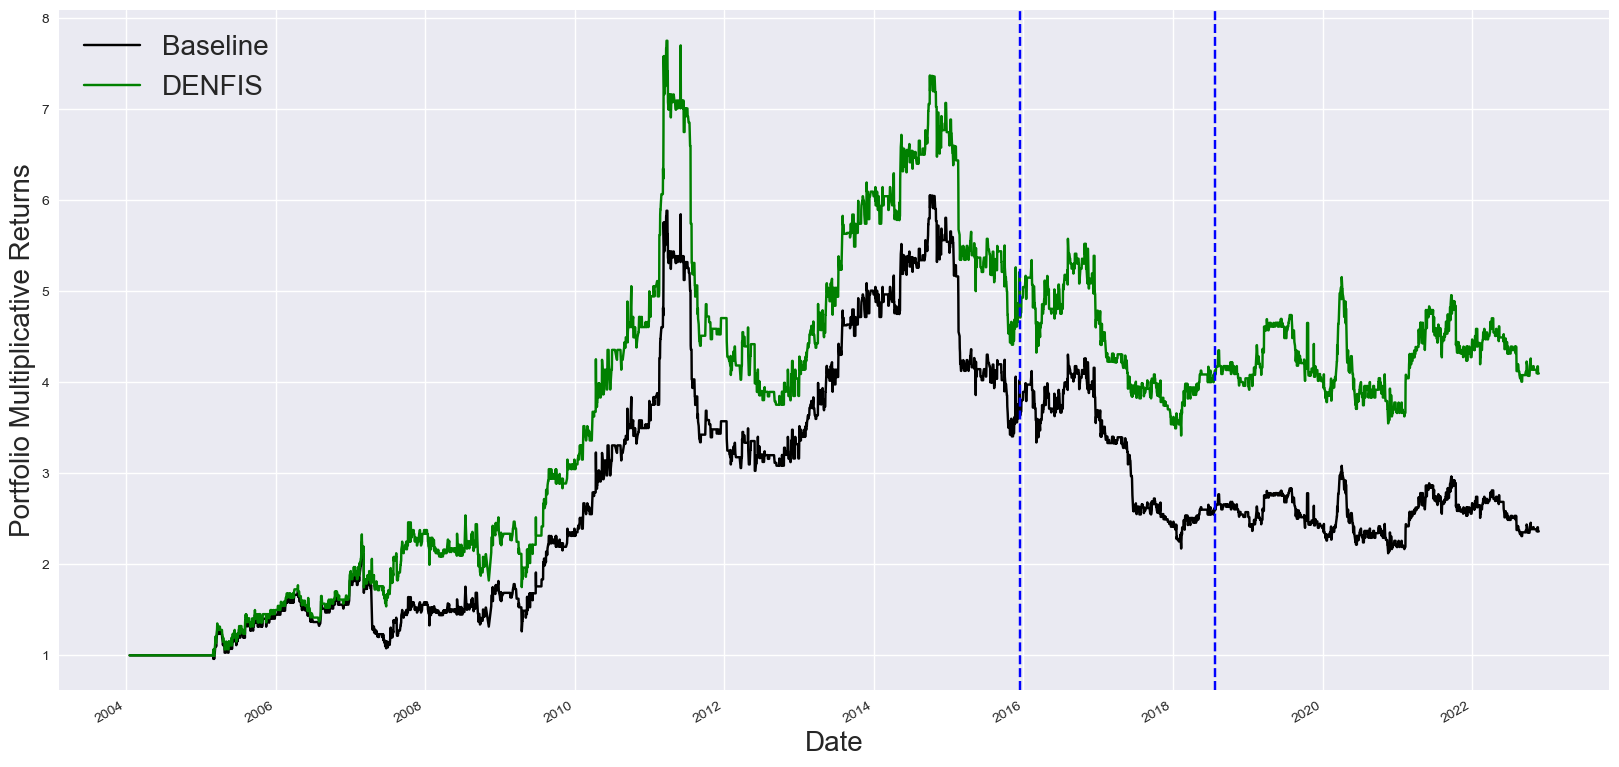

In [12]:
# Place predicted train, val & test 'Close' prices into df2
predicted = np.concatenate((y_train_pred, y_val_pred, y_test_pred))
predicted = predicted[:,0]
index_labels = chlngr_df.index.array[num_days:num_rows-1]
df2 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

print(f'Start date of df: {df.index[0]}')
print(f'End date of df: {df.index[-1]}')
print(f'Start date of df2: {df2.index[0]}')
print(f'End date of df2: {df2.index[-1]}')

# Compute DENFIS Returns
compute_trade_signals_predicted(df2,plt_pos=False, plt_trade=False)
df2 = compute_returns(df2, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

# Plot Memberships of DENFIS

D_threshold = 0.21
Clusters_center are: 
 [[0.64698035 0.44412687 0.6113555 ]
 [0.19889271 0.54320693 0.52634746]
 [0.75325197 0.13688624 0.5217914 ]
 [0.537115   0.58290535 0.18648128]
 [0.7036154  0.8676906  0.54166687]
 [0.46136734 0.5549734  0.77690274]]
beta are: 
 [[1.4531859 1.993547  1.4260217]
 [1.9551038 1.8889903 1.2798728]
 [1.254464  1.5310522 1.8123513]
 [1.7848424 1.7951304 1.2916813]
 [1.2569497 1.4365888 1.5856079]
 [1.6709421 1.5641642 1.6174499]]


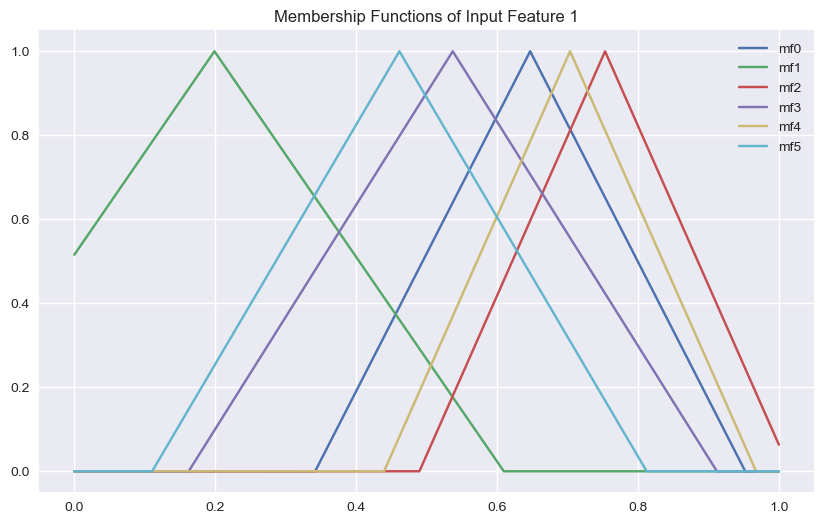

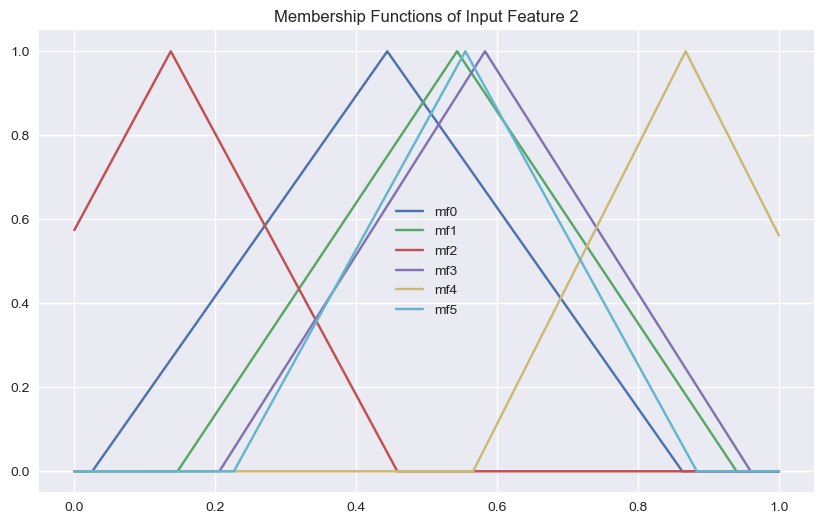

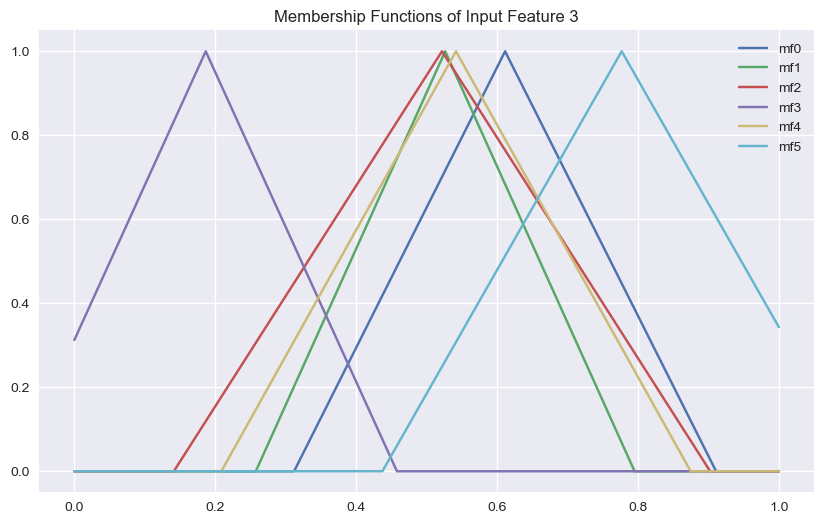

In [13]:
print(f'D_threshold = {D_threshold}')
print(f'Clusters_center are: \n {Clusters_center}')
print(f'beta are: \n {beta[0]}')

x = np.linspace(0,1,10001)
for i in range(len(Clusters_center[0])): #repeat for each feature
    plt.figure(figsize = (10,6))
    for j in range(len(Clusters_center)):# repeat for each membership function
        b = Clusters_center[j,i]
        a = b - beta[0][j,i]*D_threshold
        c = b + beta[0][j,i]*D_threshold
        y = np.where(x<a, 0, np.where(x<b, (x-a)/(b-a), np.where(x<c, (c-x)/(c-b), 0)))
        y = np.reshape(y, [10001])
        plt.plot(x, y, label=f'mf{j}')
        plt.title(f'Membership Functions of Input Feature {i+1}')
    plt.legend(fontsize=10)


# Benchmark: ANFIS

(modified from https://github.com/gregorLen/AnfisTensorflow2.0/blob/c2694cb433d83cd7712246e25579b36753adb985/Models/myanfis.py#L173)

input_ type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 3)
L1 output type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 6, 3)
L2 output type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L3 output type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L4 output type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 216)
L5 output type: <class 'keras.engine.keras_tensor.KerasTensor'> and shape (1, 1)
Epoch 1/30
2616/2616 [==============================] - 2s 650us/step - loss: 0.0039 - val_loss: 0.0052
Epoch 2/30
2616/2616 [==============================] - 2s 625us/step - loss: 0.0025 - val_loss: 0.0043
Epoch 3/30
2616/2616 [==============================] - 2s 625us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4/30
2616/2616 [==============================] - 2s 628us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 5/30
2616/2616 [==============================] - 2s 625us/step - loss: 0.0019 - val_l

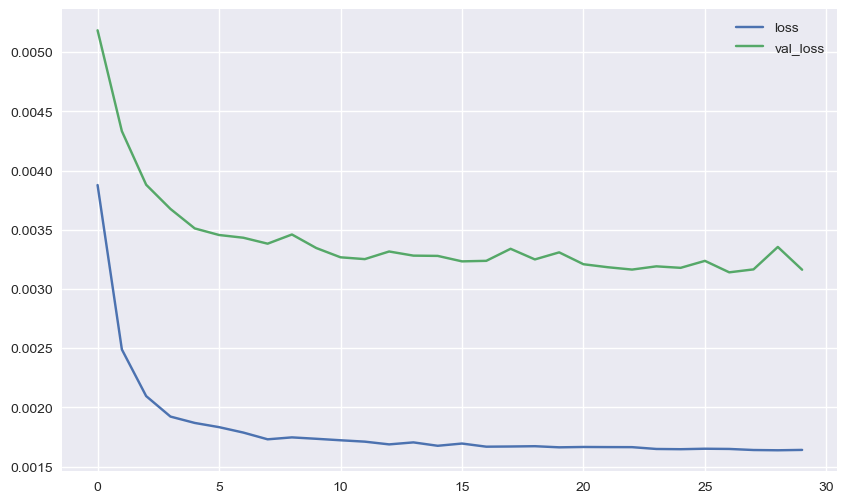

In [14]:
X_train = X[0:num_train,:]
y_train = Y[0:num_train]
X_val = X[num_train:num_val,:]
y_val = Y[num_train:num_val]
X_test = X[num_val:num_test,:]
y_test = Y[num_val:num_test]

# set parameters
param = fis_parameters(
    n_input=len(X_train[0]),                # no. of Regressors
    n_memb=6,                 # no. of fuzzy memberships
    batch_size=1,            # 16 / 32 / 64 / ...
    memb_func='gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer='sgd',          # sgd / adam / ...
    # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    loss='mse',
    n_epochs=30              # 10 / 25 / 50 / 100 / ...
)

# plt.style.use('seaborn')                # default / ggplot / seaborn
# plot_prediction = True                  # True / False

fis = ANFIS(n_input=param.n_input,
            n_memb=param.n_memb,
            batch_size=param.batch_size,
            memb_func=param.memb_func,
            name='myanfis'
           )

# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
#                    metrics=['mse']  # ['mae', 'mse']
                  )

# fit model
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_val, y_val),
                  )
# eval model
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(10, 6))
fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()

# get consequence paramters
bias = fis.bias
weights = fis.weights

Plot ANFIS Model Train & Val Predictions

2616/2616 [==============================] - 1s 426us/step


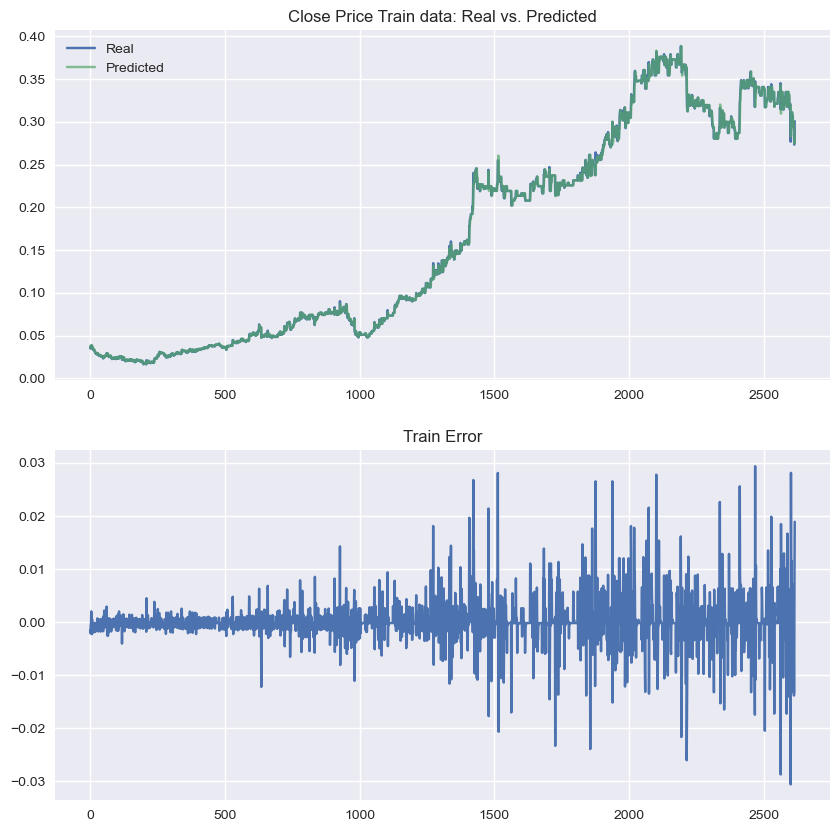

654/654 [==============================] - 0s 427us/step


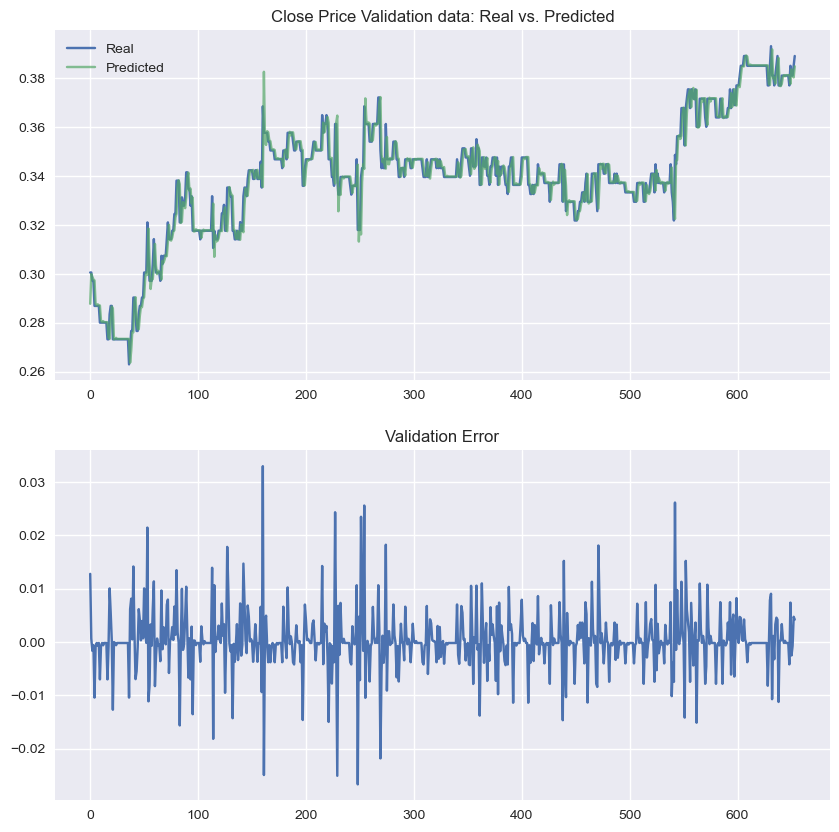

In [15]:
# Plot train data vs predicted of train data
y_train_pred_b4 = fis(X_train) # predicted scaled delta
y_train_pred = scaler_Y.inverse_transform(y_train_pred_b4) # predicted unscaled delta
y_train_pred = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train_pred # predicted unscaled 'Close' price

y_train = scaler_Y.inverse_transform(y_train) # real unscaled delta
y_train = np.reshape(df['Close'][0:num_train].values, [-1,1]) + y_train # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_train)
axs[0].plot(y_train_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Train data: Real vs. Predicted')

axs[1].plot(np.arange(y_train.shape[0]), y_train - y_train_pred)
axs[1].grid(True)
axs[1].set_title('Train Error')
plt.show()

# Plot val data vs predicted of val data    
y_val_pred_b4 = fis(X_val) # predicted scaled delta
y_val_pred = scaler_Y.inverse_transform(y_val_pred_b4) # predicted unscaled delta
y_val_pred = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val_pred # predicted unscaled 'Close' price

y_val = scaler_Y.inverse_transform(y_val) # real unscaled delta
y_val = np.reshape(df['Close'][num_train:num_val].values, [-1,1]) + y_val # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_val)
axs[0].plot(y_val_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Validation data: Real vs. Predicted')
axs[1].plot(np.arange(y_val.shape[0]), y_val - y_val_pred)
axs[1].grid(True)
axs[1].set_title('Validation Error')
plt.show()

Plot Multiplicative Returns of ANFIS Train & Val  Predictions vs Baseline

Text(0.5, 0, 'Date')

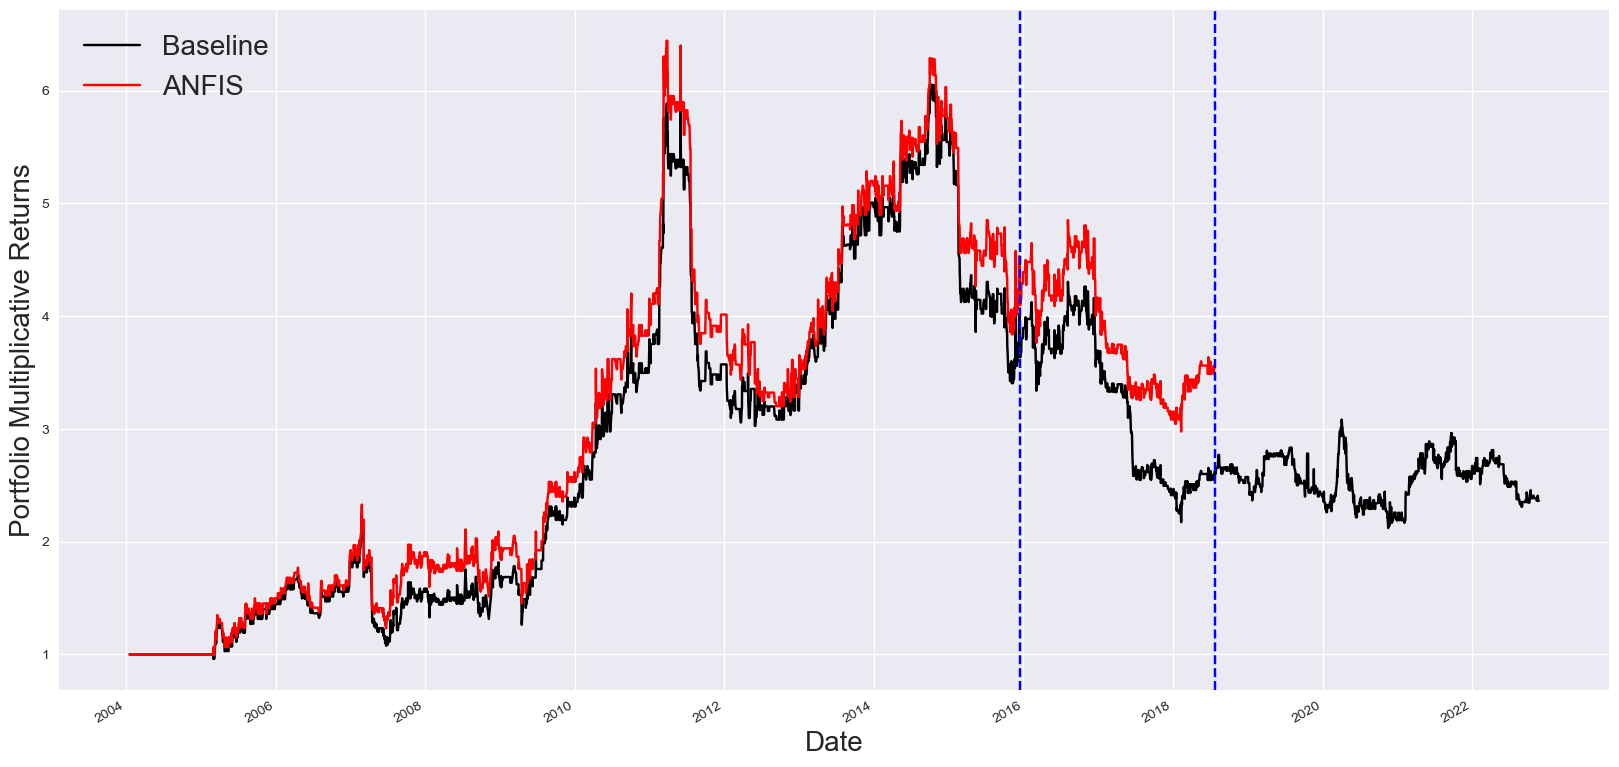

In [16]:
# Place predicted train & val 'Close' prices into df3
predicted = np.concatenate((y_train_pred, y_val_pred))
predicted = predicted[:,0]
index_labels = df.index.array[0:num_val]
df3 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute ANFIS Returns
compute_trade_signals_predicted(df3,plt_pos=False, plt_trade=False)
df3 = compute_returns(df3, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df3['Returns'].plot(color = 'r', label= 'ANFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

ANFIS Model Test Data Prediction

1091/1091 [==============================] - 0s 428us/step


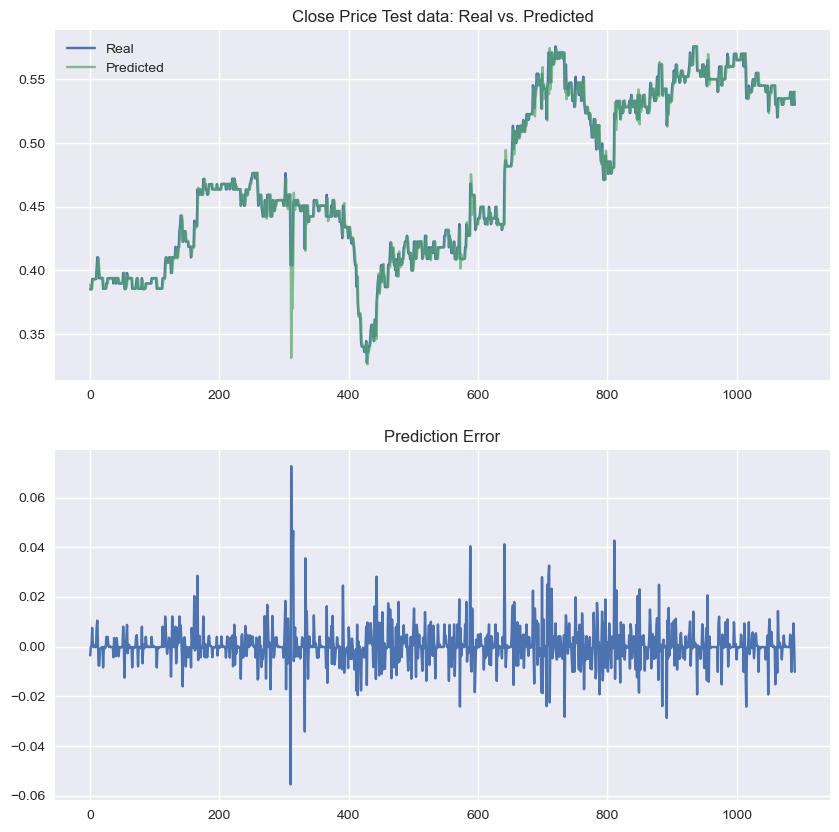

In [17]:
# Plot test data vs predicted of test data
y_test_pred_b4 = fis(X_test) # predicted scaled delta
y_test_pred = scaler_Y.inverse_transform(y_test_pred_b4) # predicted unscaled delta
y_test_pred = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test_pred # predicted unscaled 'Close' price

y_test = scaler_Y.inverse_transform(y_test) # real unscaled delta
y_test = np.reshape(df['Close'][num_val:num_test].values, [-1,1]) + y_test # real unscaled 'Close' price

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(y_test)
axs[0].plot(y_test_pred, alpha=.7)
axs[0].legend(['Real', 'Predicted'])
axs[0].grid(True)
axs[0].set_title('Close Price Test data: Real vs. Predicted')
axs[1].plot(np.arange(y_test.shape[0]), y_test - y_test_pred)
axs[1].grid(True)
axs[1].set_title('Prediction Error')
plt.show()

Plot Multiplicative Returns of ANFIS Train, Val & Test Predictions vs Baseline

Text(0.5, 0, 'Date')

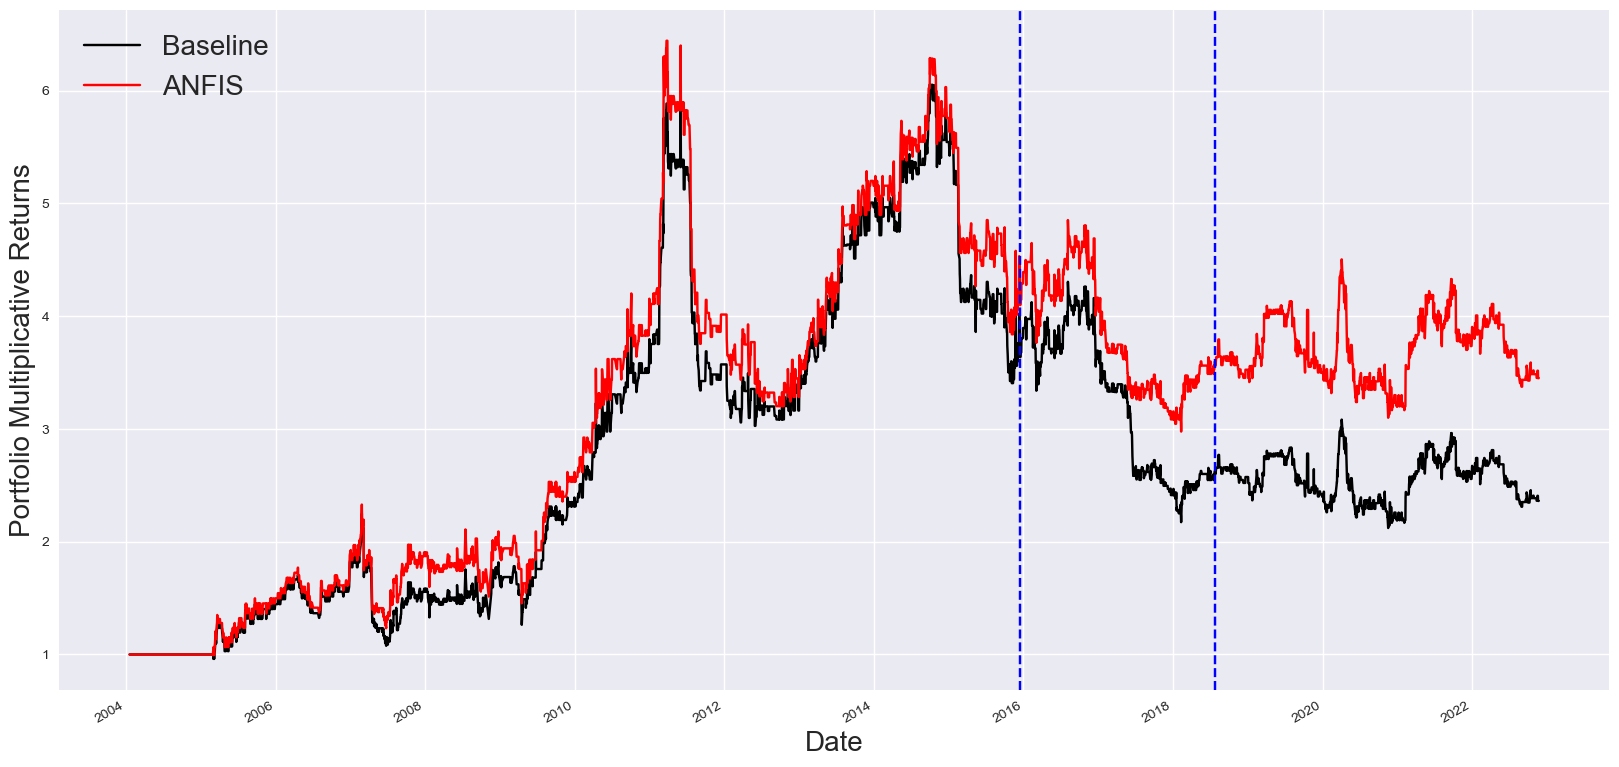

In [18]:
# Place predicted train, val & test 'Close' prices into df3
predicted = np.concatenate((y_train_pred, y_val_pred, y_test_pred))
predicted = predicted[:,0]
index_labels = chlngr_df.index.array[num_days:num_rows-1]
df3 = pd.DataFrame(predicted, index=index_labels, columns=['Close'])

# Compute ANFIS Returns
compute_trade_signals_predicted(df3,plt_pos=False, plt_trade=False)
df3 = compute_returns(df3, 0.005)

# Plot Multiplicative Returns
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df3['Returns'].plot(color = 'r', label= 'ANFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

# Plot Memberships of ANFIS

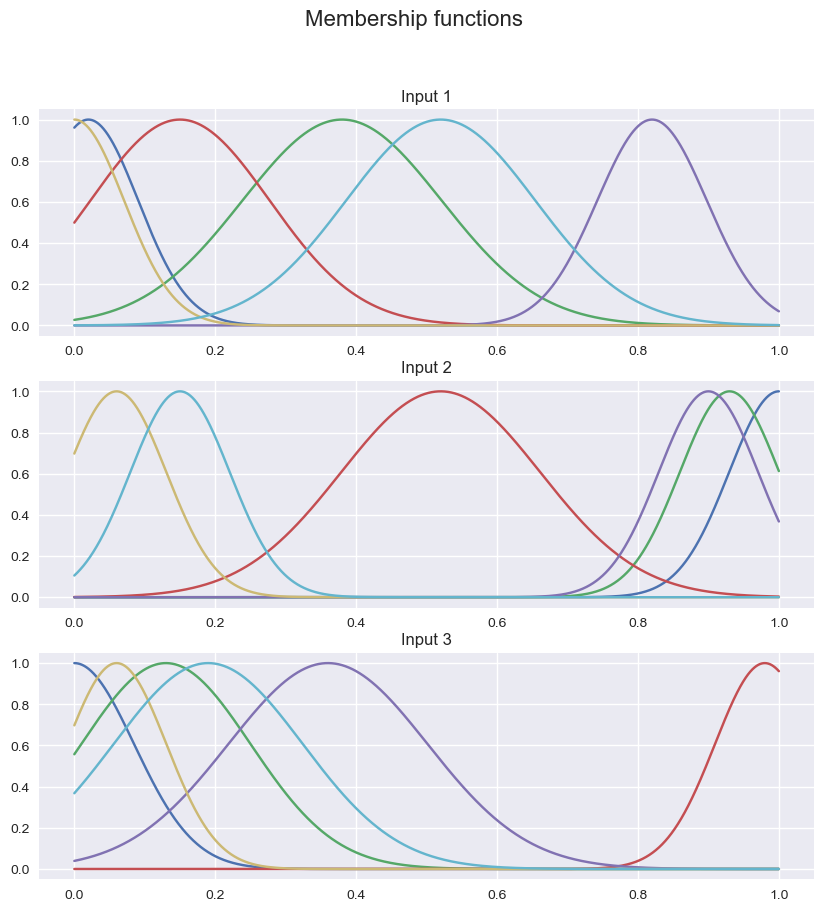

In [19]:
fis.plotmfs(show_initial_weights=False)

# Portfolio Returns of DENFIS VS ANFIS VS Baseline

Text(0.5, 0, 'Date')

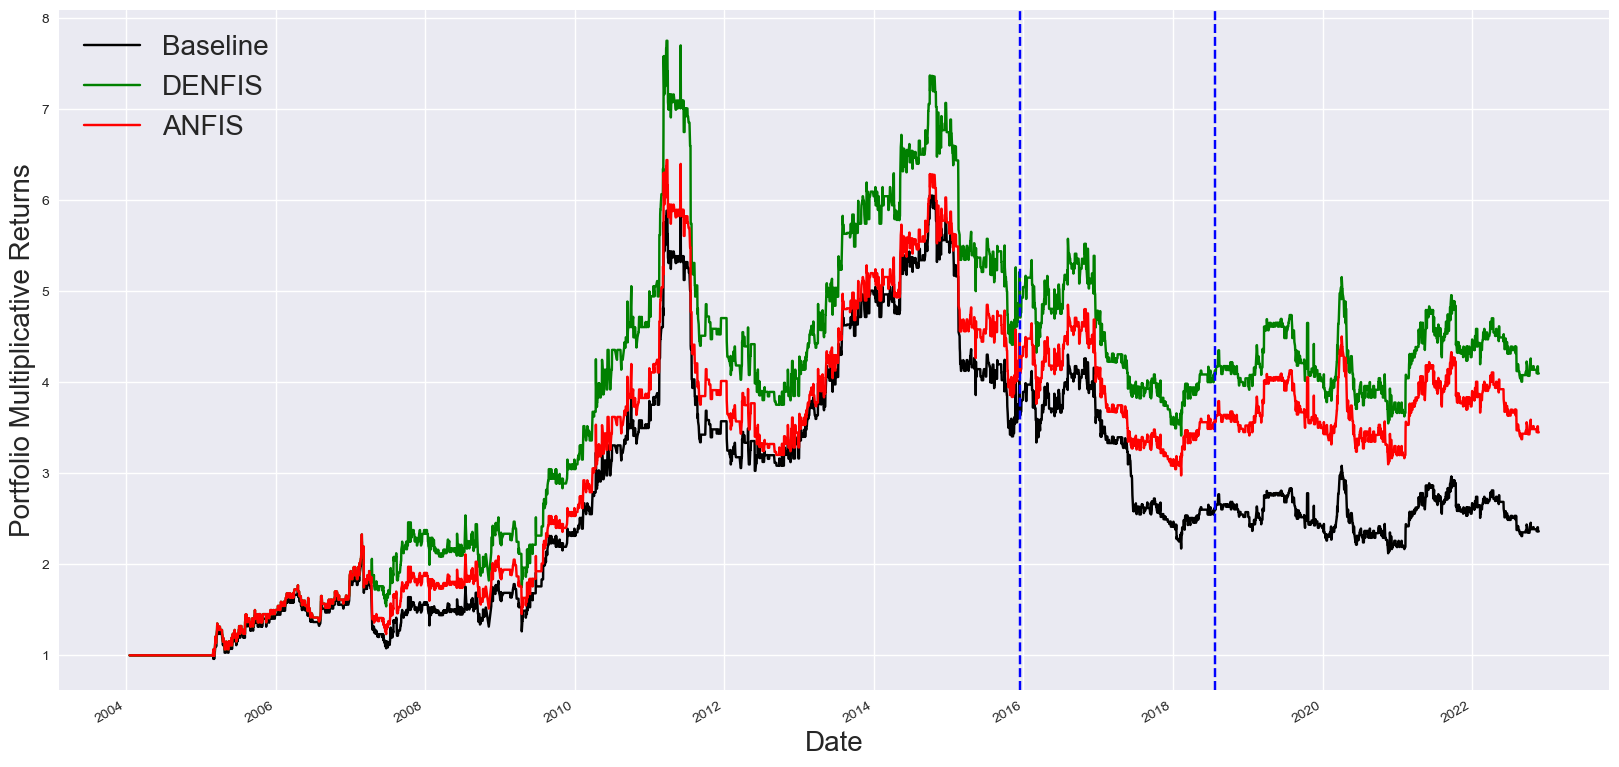

In [20]:
plt.figure(figsize = (20,10))
df['Returns'].plot(color = 'k', label= 'Baseline')
df2['Returns'].plot(color = 'g', label= 'DENFIS')
df3['Returns'].plot(color = 'r', label= 'ANFIS')
plt.axvline(num_train_date, color='b', linestyle='--')
plt.axvline(num_val_date, color='b', linestyle='--')
plt.legend(loc=2, fontsize=20)
plt.ylabel('Portfolio Multiplicative Returns', size=20)
plt.xlabel('Date', size=20)

# Result Analysis

plot_price to see original 'Close' price with predicted SMA, FMA, Buy and Sell signals

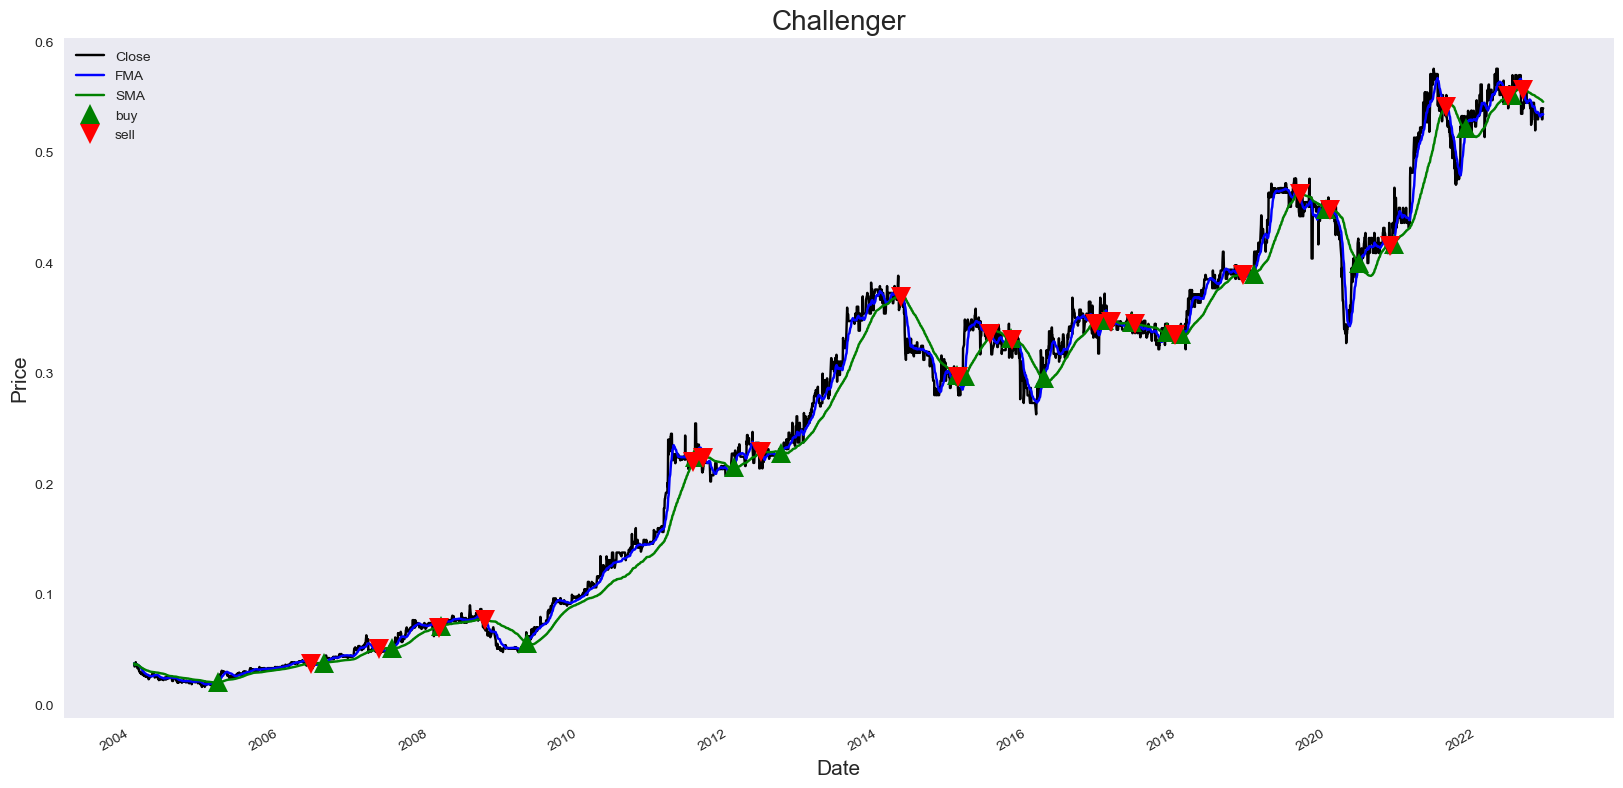

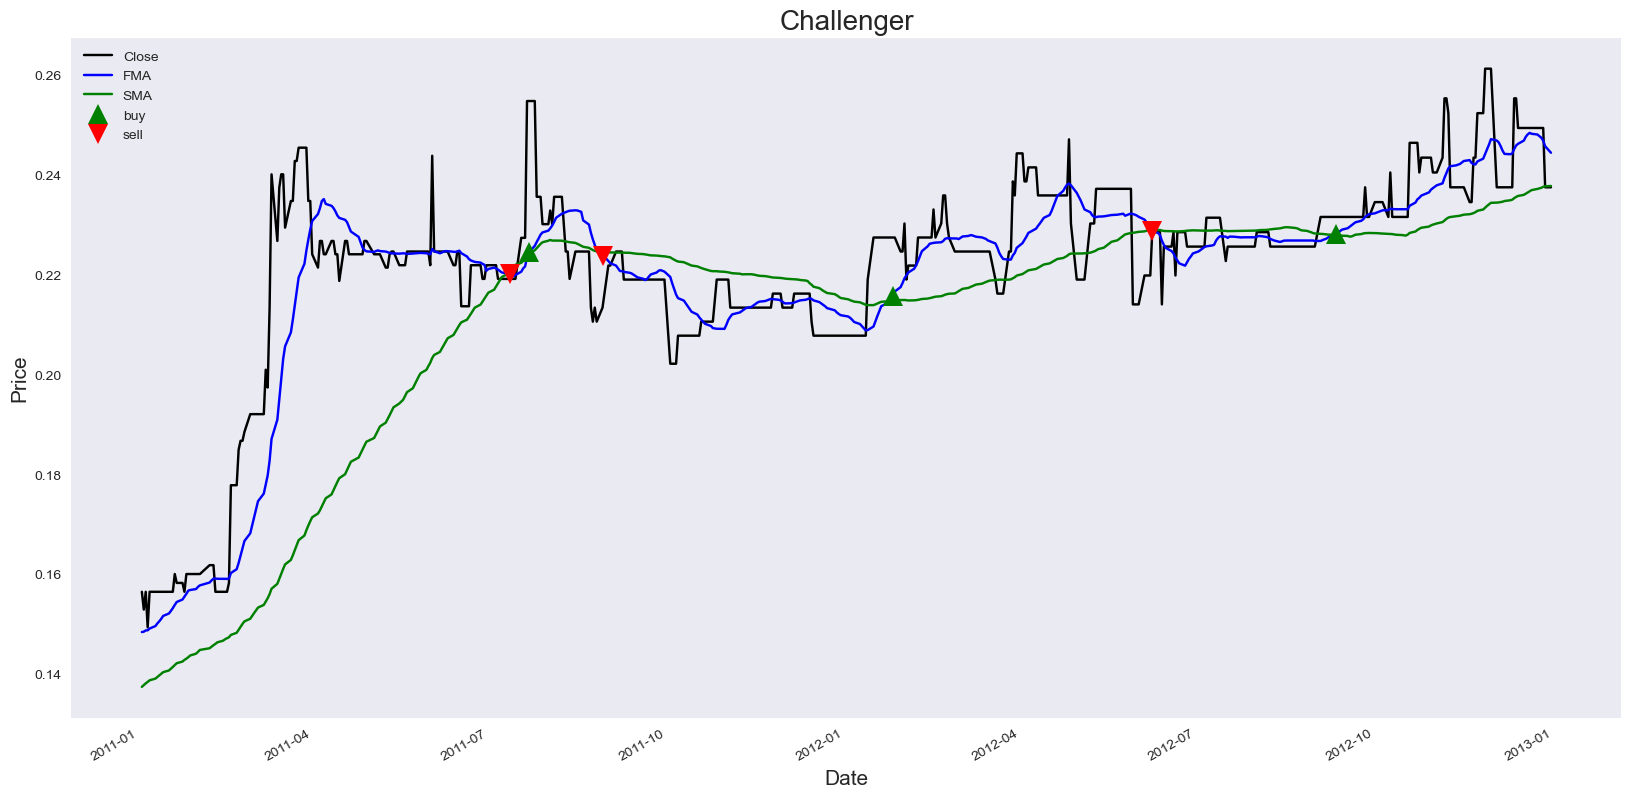

In [21]:
plot_price(df2, time_period=False)
plot_price(df2['2011-01-01':'2011-12-31'], time_period=True)

compare_trade_signals to see original 'Close' price, SMA, FMA, and trade signals with vs without forecast

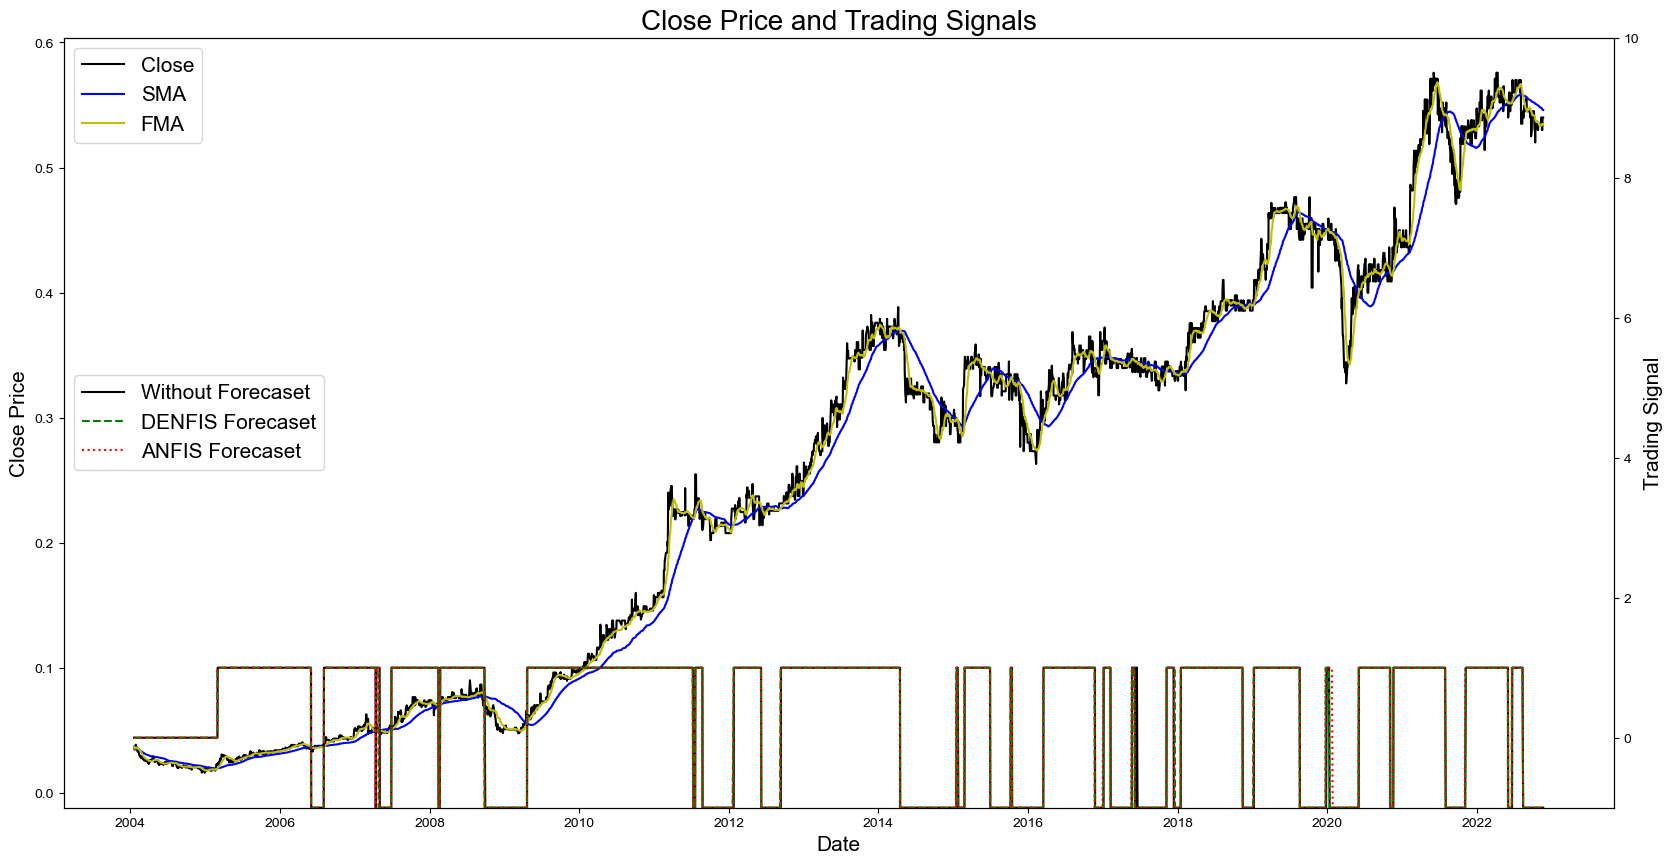

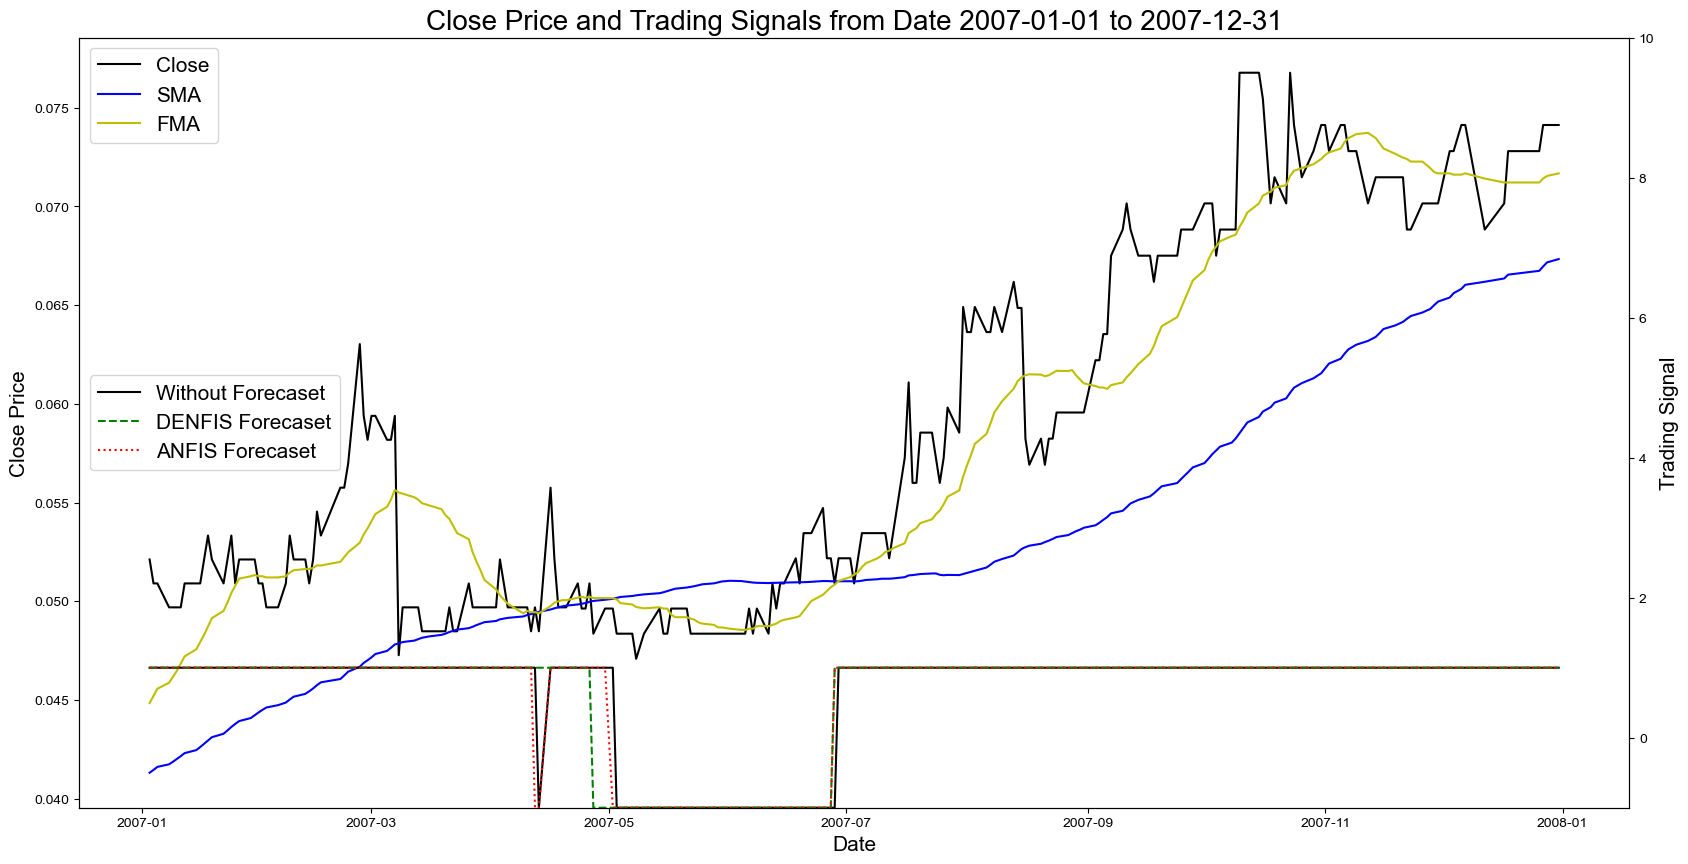

In [22]:
compare_trade_signals(False, '0', '0')
compare_trade_signals(True, '2007-01-01', '2007-12-31')

In [23]:
print('Original:')
print(df['2007-04-01':'2007-05-31']['Trade'])
print('DENFIS:')
print(df2['2007-04-01':'2007-05-31']['Trade'])
print('ANFIS:')
print(df3['2007-04-01':'2007-05-31']['Trade'])

Original:
Date
2007-04-02 00:00:00+08:00    1.0
2007-04-03 00:00:00+08:00    1.0
2007-04-05 00:00:00+08:00    1.0
2007-04-09 00:00:00+08:00    1.0
2007-04-10 00:00:00+08:00    1.0
2007-04-11 00:00:00+08:00    1.0
2007-04-12 00:00:00+08:00    1.0
2007-04-13 00:00:00+08:00   -1.0
2007-04-16 00:00:00+08:00    1.0
2007-04-17 00:00:00+08:00    1.0
2007-04-18 00:00:00+08:00    1.0
2007-04-19 00:00:00+08:00    1.0
2007-04-20 00:00:00+08:00    1.0
2007-04-23 00:00:00+08:00    1.0
2007-04-24 00:00:00+08:00    1.0
2007-04-25 00:00:00+08:00    1.0
2007-04-26 00:00:00+08:00    1.0
2007-04-27 00:00:00+08:00    1.0
2007-04-30 00:00:00+08:00    1.0
2007-05-02 00:00:00+08:00    1.0
2007-05-03 00:00:00+08:00   -1.0
2007-05-04 00:00:00+08:00   -1.0
2007-05-07 00:00:00+08:00   -1.0
2007-05-08 00:00:00+08:00   -1.0
2007-05-10 00:00:00+08:00   -1.0
2007-05-14 00:00:00+08:00   -1.0
2007-05-15 00:00:00+08:00   -1.0
2007-05-16 00:00:00+08:00   -1.0
2007-05-17 00:00:00+08:00   -1.0
2007-05-18 00:00:00+08:00   